<div class="alert alert-block alert-info">
<center> <h1> Text Mining - Predicting Airbnb Unlisting </h1> </center> <br>
    
    
<center>University: NOVA Information Management School</center> <br>
<center>Program: Master’s Degree Program in Data Science and Advanced Analytics</center> <br>
<center>Academic Year: 2022/2023</center> <br>
<center> Group 17 </center> <br>
<center>=========================Students=========================</center> <br>
<center> Iryna Savchuk (m20211310@novaims.unl.pt) </center> <br>
<center> Cátia Parrinha (m20201320@novaims.unl.pt) </center> <br>
<center> Pedro Anastácio (m20180040@novaims.unl.pt) </center> <br>
<center>==========================================================</center> <br>

**Table of Contents** <br>
* [1.Data Import](#dataimport)
    * [1.1.Import Libraries](#importlibraries)
    * [1.2.Import Datasets](#importdatasets)
        * [1.2.1. Airbnb](#airbnb)
        * [1.2.2. Reviews](#reviews)
* [2.Data Exploration](#dataexploration)
    * [2.1. Checking shapes](#traindataset)
    * [2.2. Data Profiling](#dataprofiling)
    * [2.3. Missing Values](#missingvalues)
    * [2.4. Target exploration](#targetexploration)
    * [2.5. Text Features Data Exploration](#independentdataexploration)
        * [2.5.1. Word Counts](#wordcounts)
        * [2.5.2. Word Clouds](#wordcoulds)
        * [2.5.3. Duplicates](#duplicates)
        * [2.2.4. Explore Languages](#language)
        * [2.5.5. Summary of Exploratory Analysis](#summary)
* [3.Data Preprocessing](#datapreprocessing)
* [4.Define Training Features](#training_features)
    * [4.1. Bag of Words (Bow)](#bow)
    * [4.2. TF_IDF](#tf-idf)
        * [4.2.1. 1-Gram](#tf-idf-1gram)
        * [4.2.2. 2-Gram](#tf-idf-2gram)
* [5. Classification Models](#classificationmodels)
    * [5.1. KNeighborsClassifier](#KNN)
        * [5.1.1. Bow](#KNN_bow)
        * [5.1.2. TF_IDF 1-Gram](#KNN_tfidf-1gram)   
        * [5.1.3 TF_IDF 2-Gram](#KNN_tfidf-2gram)
    * [5.2. Random Forest](#randomforest)
        * [5.2.1. Bow](#randomforest_bow)
        * [5.2.2. TF_IDF 1-Gram](#randomforest_tfidf-1gram)
        * [5.2.3. TF_IDF 2-Gram](#randomforest_tfidf-2gram)
    * [5.3. Naive Bayes](#naivebayes)
        * [5.3.1 Bow](#nb_bow)
    * [5.4. Logistic Regression](#logisticregression)
        * [5.4.1 Bow](#lr_bow)
    * [5.5. Neural Networks](#nn)
        * [5.4.1 Bow](#nn_bow)  
    * [5.6. Grid Search](#gridsearch)

<hr>
<a class="anchor" id="dataimport">
    
# 1. Data Import
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 1.1. Import Libraries
    
</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud
import csv
import os

# Profiling Report
from ydata_profiling import ProfileReport

# Clean Data
from bs4 import BeautifulSoup

# Tokenization
import nltk
from nltk.tokenize import word_tokenize

# Punctuation
import string

# Stop Words
from nltk.corpus import stopwords

# Regular Expressions
import re

# Stemming and Lemmatization
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# For displaying progress bars during iterative tasks
from tqdm import tqdm

# Data Partition
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

# Create BoW - Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluate
from sklearn.metrics import classification_report

# confusion_matrix
from sklearn.metrics import confusion_matrix

# Language detector
from langdetect import detect

# Remove emoji
import emoji

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Fine Tuning
from sklearn.model_selection import GridSearchCV

# To avoid have warnings
import warnings
warnings.filterwarnings("ignore")

<hr>
<a class="anchor" id="importdatasets">
    
## 1.2. Import Datasets
    
</a>

<hr>
<a class="anchor" id="airbnb">
    
### 1.2.1. Airbnb
    
</a>

In [2]:
airbnb_df_train = pd.read_excel('Project Corpora/train.xlsx')
airbnb_df_train.head(3)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1


In [3]:
airbnb_df_test = pd.read_excel('Project Corpora/test.xlsx')
airbnb_df_test.head(3)

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."


<hr>
<a class="anchor" id="reviews">
    
### 1.2.2. Reviews
    
</a>

In [4]:
reviews_df_train = pd.read_excel('Project Corpora/train_reviews.xlsx')
reviews_df_train.head(3)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."


In [5]:
reviews_df_test = pd.read_excel('Project Corpora/test_reviews.xlsx')
reviews_df_test.head(3)

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...


<hr>
<a class="anchor" id="dataexploration">
    
# 2. Data Exploration
    
</a>

<hr>
<a class="anchor" id="traindataset">
    
## 2.1. Checking shapes
    
</a>

In [6]:
print("Train shape:", airbnb_df_train.shape)
print("Train reviews shape:", reviews_df_train.shape)
print("------------------")
print("Test shape:", airbnb_df_test.shape)
print("Test reviews shape:", reviews_df_test.shape)

Train shape: (12496, 4)
Train reviews shape: (721402, 2)
------------------
Test shape: (1389, 3)
Test reviews shape: (80877, 2)


<hr>
<a class="anchor" id="dataprofiling">
    
## 2.2. Data Profiling
</a>

In [7]:
# Generate a profile report for the the train DataFrame and save it to /output
profile = ProfileReport(airbnb_df_train, title="Profiling Report")
profile.to_file("output/airbnb_report.html")

# Reset the matplotlib backend for the rest of the notebook
plt.switch_backend("module://ipykernel.pylab.backend_inline")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<hr>
<a class="anchor" id="missingvalues">
    
## 2.3. Missing Values
    
</a>

In [8]:
airbnb_df_train.isna().sum()

df_index       0
description    0
host_about     0
unlisted       0
dtype: int64

<div class="alert alert-block alert-success">
    There are no missing values in the <b> airbnb train </b> dataset columns.

In [9]:
reviews_df_train.isna().sum()

index       0
comments    0
dtype: int64

<div class="alert alert-block alert-success">
    There are no missing values in the <b> review train </b> dataset.

<hr>
<a class="anchor" id="targetexploration">
    
## 2.4. Target exploration
    
</a>

Check unique values for the target labels:

In [10]:
(airbnb_df_train['unlisted']).unique()

array([0, 1])

In [11]:
airbnb_df_train['unlisted'].value_counts()

0    9033
1    3463
Name: unlisted, dtype: int64

There is a better to visualize it target labels proportion:

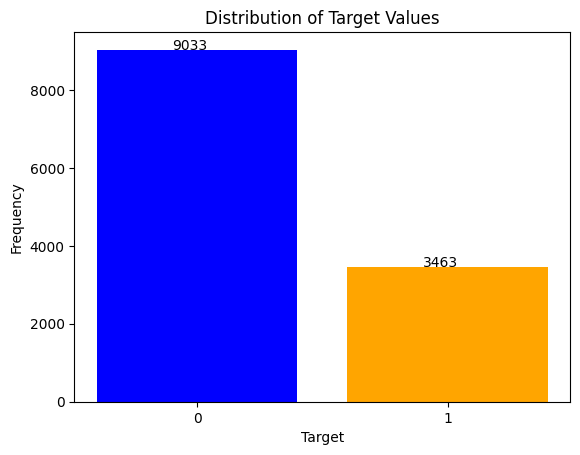

In [12]:
# Calculate the frequency of each rating
counts = airbnb_df_train['unlisted'].value_counts()

# Create a bar chart of the ratings
colors = ['blue', 'orange']
plt.bar(counts.index, counts.values, color=colors)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Distribution of Target Values')
plt.xticks(range(0, 2))

# Add the value of each bar to the plot
for i, v in enumerate(counts.values):
    plt.text(counts.index[i] - 0.1, v + 0.1, str(v))

plt.show()

In [13]:
airbnb_df_train['unlisted'].value_counts(normalize = True)

0    0.722871
1    0.277129
Name: unlisted, dtype: float64

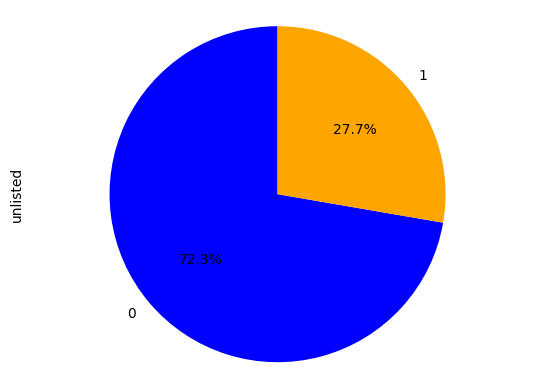

In [14]:
airbnb_df_train['unlisted'].value_counts().plot(kind='pie', 
                                             labels=airbnb_df_train['unlisted'].unique(), 
                                             autopct='%1.1f%%', 
                                             startangle=90, colors=colors)
plt.axis('equal')
plt.show()

<div class="alert alert-block alert-danger">  
The <b> train </b> dataset has an unbalanced target variable, with 72.3% of values being '0' and the rest of the values being '1'.
</div>

<hr>
<a class="anchor" id="independentdataexploration">
    
## 2.5. Text Features exploration
    
</a>

We have 2 textual columns in train 'airbnb_df_train'("description" and "host_about") and one textual feature in 'reviews_df_train' (named "comments"). 

Let's perfrom the Exploratory Analysis for these three textual features.

<hr>
<a class="anchor" id="wordcounts">
    
### 2.5.1. Word Counts
    
</a>

We will split our texts into tokens and count how many tokens exist in each document.

**description**

In [15]:
airbnb_df_train['word_count_description']  = airbnb_df_train['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['description','word_count_description']].head()

,description,word_count_description
0,"This is a shared mixed room in our hostel, wit...",127
1,"O meu espaço fica perto de Parque Eduardo VII,...",23
2,Trafaria’s House is a cozy and familiar villa ...,170
3,"Apartamento Charmoso no Chiado, Entre o Largo ...",47
4,Joli appartement en bordure de mer.<br /> 2 m...,101


Descriptive Statistics of word count

In [16]:
airbnb_df_train.word_count_description.describe()

count    12496.000000
mean       132.663572
std         48.494104
min          3.000000
25%         99.000000
50%        157.000000
75%        167.000000
max        210.000000
Name: word_count_description, dtype: float64

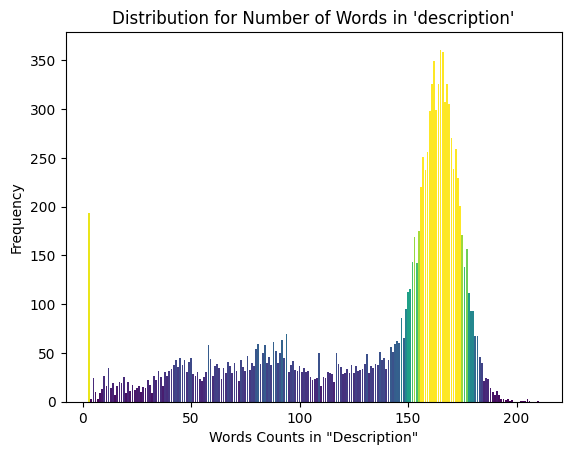

In [17]:
# Calculate the frequency of each rating
counts_desc = airbnb_df_train['word_count_description'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_desc.index, counts_desc.values, color=colormap(counts_desc.values))
plt.xlabel('Words Counts in "Description"')
plt.ylabel('Frequency')
plt.title("Distribution for Number of Words in 'description'")

plt.show()

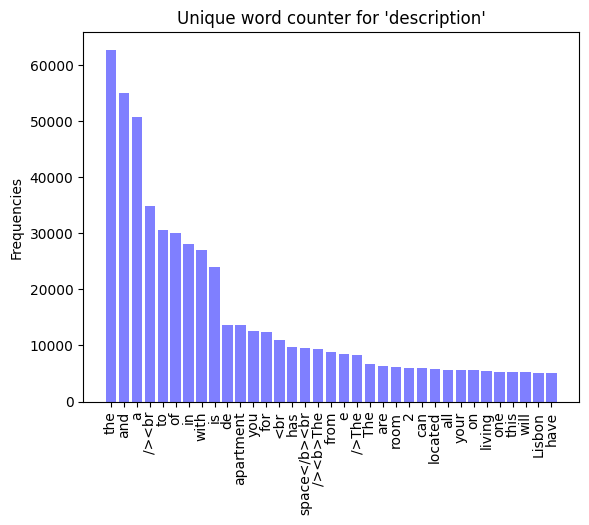

In [18]:
# Create a list with all words in airbnb_df_train['description']
all_words_desc = ' '.join(airbnb_df_train['description']).split()
# The frequency of each word
freq_desc = pd.Series(all_words_desc).value_counts()

# A bar plot with the top 35 words, from description column
x_labels = freq_desc.index[0:35]
values = freq_desc[:35]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title("Unique word counter for 'description'")
plt.xticks(rotation=90)
plt.show()


**host_about**

In [19]:
airbnb_df_train['word_count_host_about']  = airbnb_df_train['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train[['host_about','word_count_host_about']].head()

,host_about,word_count_host_about
0,Alojamento Local Registro: 20835/AL,4
1,"I am friendly host, and I will try to always b...",24
2,"I am a social person liking to communicate, re...",45
3,Hello!_x000D_\nI m Portuguese and i love to me...,31
4,Nous sommes une famille avec deux enfants de 1...,37


Descriptive Statistics of word count

In [20]:
airbnb_df_train.word_count_host_about.describe()

count    12496.000000
mean        73.031050
std         77.132867
min          1.000000
25%         26.000000
50%         55.000000
75%        102.000000
max       1387.000000
Name: word_count_host_about, dtype: float64

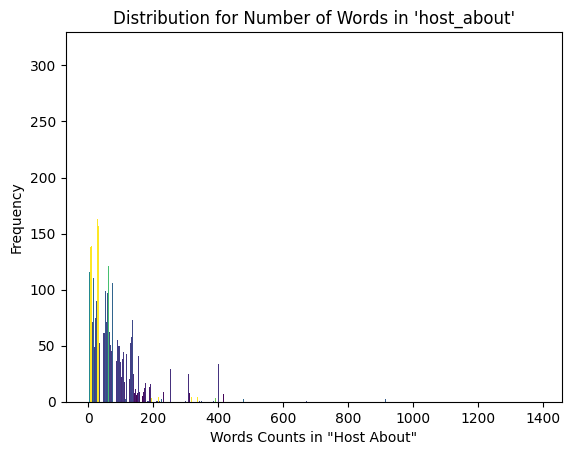

In [21]:
# Calculate the frequency of each rating
counts_host = airbnb_df_train['word_count_host_about'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_host.index, counts_host.values, color=colormap(counts_desc.values))
plt.xlabel('Words Counts in "Host About"')
plt.ylabel('Frequency')
plt.title("Distribution for Number of Words in 'host_about'")

plt.show()

In [22]:
# Exploring extreme values:
airbnb_df_train[airbnb_df_train['word_count_host_about'] > 800][['host_about', 'word_count_host_about']]

,host_about,word_count_host_about
1419,life is so much more then nice words and so ca...,922
2244,Travel is life ! I love meeting people and hel...,1387
3950,life is so much more then nice words and so ca...,922
5200,life is so much more then nice words and so ca...,922
7197,"Portuguese-Mozambican, born in Beira, Mozambiq...",864
7943,"Hi, \nMy name is Ralph Mason, I'm a '40 someth...",915
8126,"Hi, \nMy name is Ralph Mason, I'm a '40 someth...",915
9714,Travel is life ! I love meeting people and hel...,1387


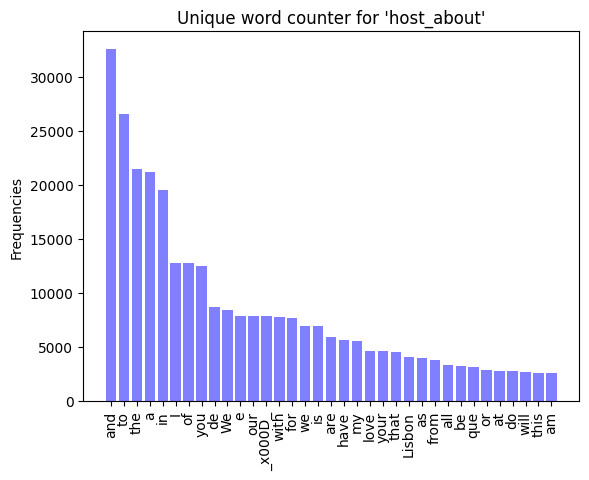

In [23]:
# Create a list with all words in airbnb_df_train['hoost_about']
all_words_host = ' '.join(airbnb_df_train['host_about']).split()
# The frequency of each word
freq_host = pd.Series(all_words_host).value_counts()

# A bar plot with the top 35 words, for 'host_about' column
x_labels = freq_host.index[0:35]
values = freq_host[:35]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title("Unique word counter for 'host_about'")
plt.xticks(rotation=90)
plt.show()

**comments**

In [24]:
reviews_df_train['word_count_comments']  = reviews_df_train['comments'].apply(lambda x: len(str(x).split(" ")))
reviews_df_train[['comments','word_count_comments']].head()

,comments,word_count_comments
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


In [25]:
reviews_df_train.word_count_comments.describe()

count    721402.000000
mean         47.993793
std          46.922807
min           1.000000
25%          18.000000
50%          36.000000
75%          63.000000
max        1064.000000
Name: word_count_comments, dtype: float64

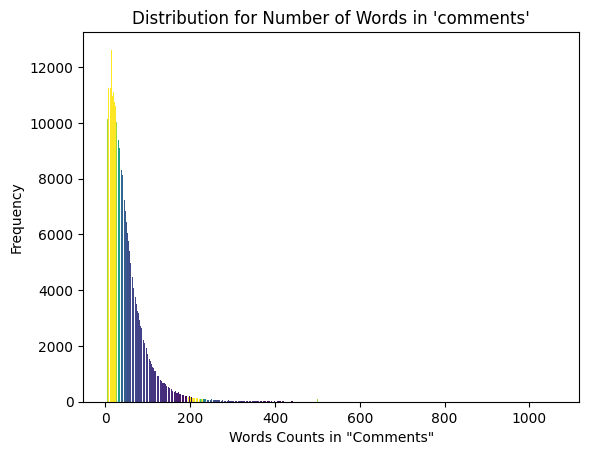

In [26]:
# Calculate the frequency of each rating
counts_host = reviews_df_train['word_count_comments'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_host.index, counts_host.values, color = colormap(counts_desc.values))
plt.xlabel('Words Counts in "Comments"')
plt.ylabel('Frequency')
plt.title("Distribution for Number of Words in 'comments'")

plt.show()

In [27]:
# Exploring extreme values:
reviews_df_train[reviews_df_train['word_count_comments'] > 1000][['comments', 'word_count_comments']]

,comments,word_count_comments
120285,This is the first bad review I have ever writt...,1019
145075,"Longe de atender minhas espectativas, vou come...",1005
174862,We strongly recommend Villa Roma Townhouse/Apt...,1003
408765,"The apartment is nice and the view is amazing,...",1007
478814,This feedback and review is based on our stay ...,1064
498296,Summary: In my 7 years of being an airbnb gues...,1001


In [28]:
# Checking if there are rows where 'comments' is numberic
numeric_column = pd.to_numeric(reviews_df_train['comments'], errors='coerce')
numeric_rows = reviews_df_train[~numeric_column.isna()] # rows with successful conversion
numeric_rows.head()

,index,comments,word_count_comments
26593,468,10,1
62305,1062,1,1
83596,1397,1,1
160070,2696,0,1
211858,3593,9,1


In [29]:
reviews_df_train['comments'] = reviews_df_train['comments'].astype('string')

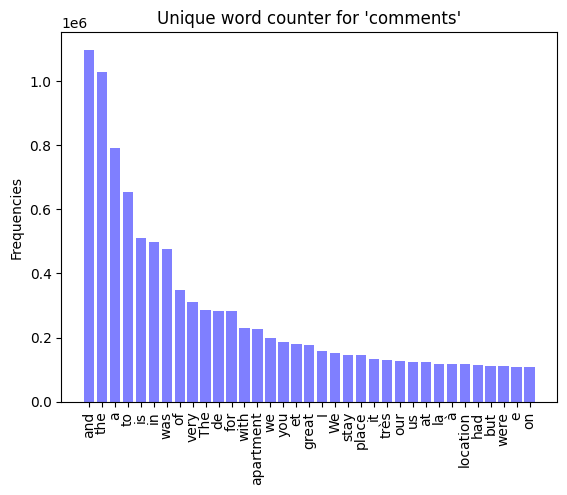

In [30]:
# Create a list with all words in reviews_df_train['comments']
all_words_comments = ' '.join(reviews_df_train['comments']).split()
# The frequency of each word
freq_host = pd.Series(all_words_comments).value_counts()

# A bar plot with the top 35 words, for 'comments' column
x_labels = freq_host.index[0:35]
values = freq_host[:35]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title("Unique word counter for 'comments'")
plt.xticks(rotation=90)
plt.show()

<hr>
<a class="anchor" id="wordcoulds">
    
### 2.5.2. Word Coulds
    
</a>

**description**

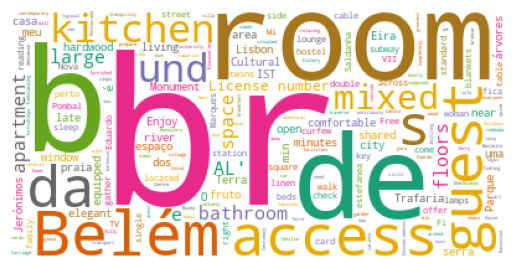

In [31]:
# Word Cloud of the feature "description" from airbnb_df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(airbnb_df_train["description"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**host_about**

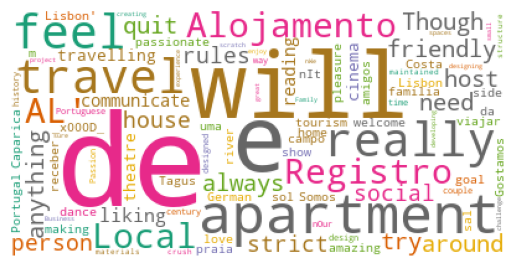

In [32]:
# Word Cloud of the feature "host_about" from airbnb_df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(airbnb_df_train["host_about"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**comments**

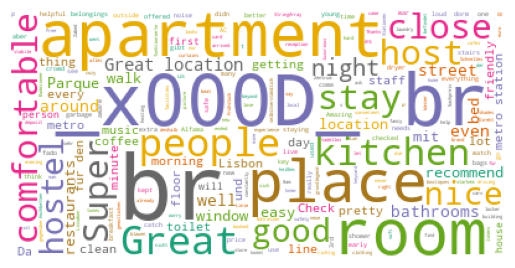

In [33]:
# Word Cloud of the feature "comments" from df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(reviews_df_train["comments"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<hr>
<a class="anchor" id="duplicates">
    
### 2.5.3. Duplicates
    
</a>

In [35]:
# Checking for duplicated values in the airbnb_df_train rows
airbnb_df_train.duplicated(subset=['description', 'host_about']).any()

True

In [36]:
# Compare the number of duplicates with the total number of rows
duplicated_rows = airbnb_df_train[airbnb_df_train.duplicated(subset=['description', 'host_about'])]
num_duplicated_rows = duplicated_rows.shape[0]
total_rows = airbnb_df_train.shape[0]

print("Number of duplicated rows in airbnb_df_train:", num_duplicated_rows)
print("Total number of rows in airbnb_df_train:", total_rows)

Number of duplicated rows in airbnb_df_train: 642
Total number of rows in airbnb_df_train: 12496


In [37]:
# What percentage of the rows are duplicates
duplicate_percentage = airbnb_df_train.duplicated(subset=['description', 'host_about']).mean() * 100
print(f"The percentage of duplicate rows in df_train is: {duplicate_percentage:.2f}%")

The percentage of duplicate rows in df_train is: 5.14%


In [38]:
# Having a look at the specific duplicated value:
specific_description_sample = '<b>Other things to note</b><br />For your information, we are carrying out work in the '\
    'apartment and because of this the kitchen will not be available, for the month of February there will be men working from '\
    '9 am to 5 pm. To compensate, you pay much less than -50% of the price usual.<br /><br /><b>License number</b><br />104691/AL'

airbnb_df_train.loc[airbnb_df_train['description']==specific_description_sample]

,df_index,description,host_about,unlisted,word_count_description,word_count_host_about
92,93,<b>Other things to note</b><br />For your info...,.,1,57,1
5352,5353,<b>Other things to note</b><br />For your info...,.,0,57,1
9285,9286,<b>Other things to note</b><br />For your info...,.,1,57,1


<hr>
<a class="anchor" id="language">
    
### 2.5.4. Explore Languages
    
</a>

In [5]:
# Define a function to detect the language of a string
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = None
    return lang

In [40]:
# Saving dataframe to .csv to later read it by chunks
airbnb_df_train.to_csv('output/train.csv', index=False)

In [41]:
# Detecting languages in the Train dataset >>>>>>>>>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/train.csv'
destination_file = 'output/train_with_language.csv'

chunk_size = 300
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['description'] = chunk['description'].str.replace('<br/>', '')
    chunk['description'] = chunk['description'].str.replace('x000D', '')
    chunk['description_language'] = chunk['description'].apply(detect_language)
    
    chunk['host_about'] = chunk['host_about'].str.replace('<br/>', '')
    chunk['host_about'] = chunk['host_about'].str.replace('x000D', '')
    chunk['host_about_language'] = chunk['host_about'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

42it [01:03,  1.51s/it]


In [43]:
reviews_df_train.to_csv('output/train_reviews.csv', index=False)

In [44]:
# Detecting languages in the Reviews dataset >>>>>>>>>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/train_reviews.csv'
destination_file = 'output/train_reviews_with_language.csv'

chunk_size = 300
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['comments'] = chunk['comments'].str.replace('<br/>', '')
    chunk['comments'] = chunk['comments'].str.replace('x000D', '')
    chunk['comments_language'] = chunk['comments'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

2405it [22:25,  1.79it/s]


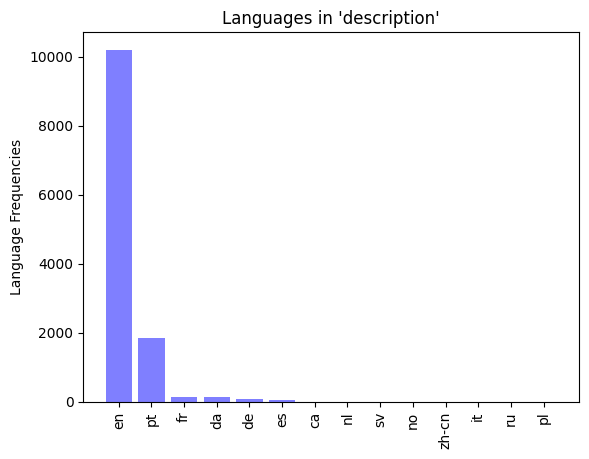

In [45]:
# Checking frequencies for languages in "description"
airbnb_language_df = pd.read_csv('output/train_with_language.csv')
freq = pd.Series(airbnb_language_df['description_language']).value_counts()
x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'blue')
plt.ylabel('Language Frequencies')
plt.title("Languages in 'description'")
plt.xticks(rotation=90)
plt.show()

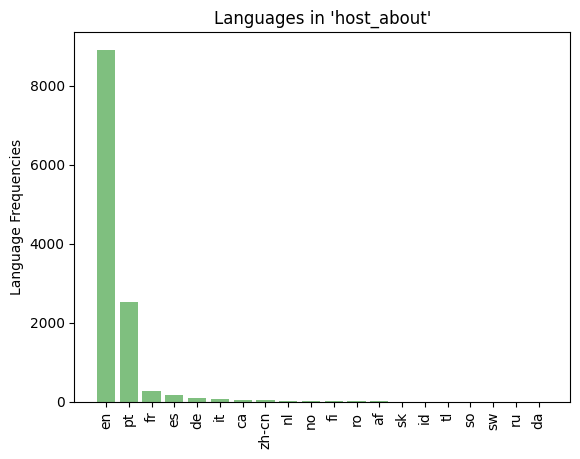

In [46]:
# Checking frequencies for languages in "host_about"
freq = pd.Series(airbnb_language_df['host_about_language']).value_counts()
x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'green')
plt.ylabel('Language Frequencies')
plt.title("Languages in 'host_about'")
plt.xticks(rotation=90)
plt.show()

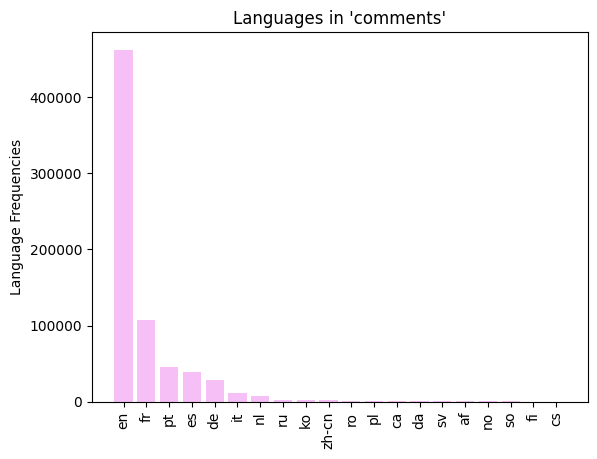

In [48]:
# Checking frequencies for languages in "comments"
reviews_languages_df = pd.read_csv('output/train_reviews_with_language.csv')
freq = pd.Series(reviews_languages_df['comments_language']).value_counts()
x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'violet')
plt.ylabel('Language Frequencies')
plt.title("Languages in 'comments'")
plt.xticks(rotation=90)
plt.show()

In [49]:
description_languages = set(airbnb_language_df['description_language'])
print("description_languages:", description_languages)
print("total number:", len(description_languages))
print("-----------------")
host_about_languages = set(airbnb_language_df['host_about_language'])
print("host_about_languages:", host_about_languages)
print("total number:", len(host_about_languages))
print("-----------------")
host_about_languages = set(reviews_languages_df['comments_language'])
print("host_about_languages:", host_about_languages)
print("total number:", len(host_about_languages))

description_languages: {'pt', 'sv', 'pl', 'es', 'de', 'ru', 'nl', 'en', 'fr', 'zh-cn', 'ca', 'da', 'it', 'no'}
total number: 14
-----------------
host_about_languages: {'pt', 'zh-tw', 'ro', 'de', 'hu', 'sk', 'af', 'da', 'sl', 'no', 'sv', 'so', 'es', 'nl', 'lt', 'it', 'he', 'tr', 'en', 'zh-cn', 'vi', 'tl', 'sw', 'cs', 'ru', 'id', 'ko', 'fr', nan, 'ca', 'fi', 'et'}
total number: 32
-----------------
host_about_languages: {'pt', 'uk', 'zh-tw', 'ro', 'de', 'hu', 'sk', 'af', 'da', 'ar', 'sl', 'no', 'sv', 'so', 'bg', 'ur', 'es', 'nl', 'sq', 'lv', 'lt', 'it', 'hr', 'ja', 'ne', 'he', 'tr', 'en', 'zh-cn', 'mk', 'th', 'cy', 'vi', 'tl', 'sw', 'pl', 'cs', 'ru', 'ko', 'id', 'hi', 'fr', nan, 'ca', 'fi', 'el', 'et'}
total number: 47


<hr>
<a class="anchor" id="summary">
    
### 2.5.5. Summary of Exploratory Analysis
    
</a>

The original 'train.xlsx' file contains 12496 rows and 4 columns: 'index', 'description', 'host_about', 'unlisted'. The 'unlisted' column is the target variable and is to be predicted based on other values.

The file 'train_reviews.xlsx' contains 721402 rows and 2 columns: 'index' and 'comments'. We will 'index' to merge information when creating the features.

During this step we counted the number words in each text column. For description column the number of words is not more than 210 words, with the most frequent value being between 150 and 180 words. For host_about it is usualy less then 200 words, but there are really long values, some of them over 1000 words. For comments it is also usualy less then 200 words, but again there are really long values, some of them over 1000 words. We will need to deal with these extreme values during the features engineering step.

Based on the wordclouds, it can be seen that the given dataset contains languages other then English - at least Portuguese(see the words like 'de', 'e', 'Alojamento', 'Belém', 'praia') and German('und', 'ist' and others). Also, there is a number of tags (such as "\<br />" and "\<b>") in our data as well as sequences of characters that are obtained after import from an Excel file (such as "x000D\n"). Thus, we will need to perform text cleaning. 
 
The dataset does not have any empty values. 

It turned out, some rows have the same values for both 'description' and 'host_about' columns, wheras 'unlisted' values are different. It means that using only 'train' dataset might be not enough for the project purpose and we might want to utilize 'reviews' data as well.

<hr>
<a class="anchor" id="datapreprocessing">
    
# 3. Data Preprocessing
    
</a>

In [ ]:
### TRAIN

In [64]:
airbnb_language_df = pd.read_csv('output/train_with_language.csv')
reviews_languages_df = pd.read_csv('output/train_reviews_with_language.csv')

In [65]:
### REMOVING HTML TAGS

In [11]:
# Creating a function to remove HTML tags
def remove_HTML_tags(df, column):
    """Function that removes HTML tags from a column containing strings in a dataframe."""
    
    # Remove HTML tags from df[column] using BeautifulSoup
    df[column] = df[column].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" ") if isinstance(x, str) else x)
    
    # Remove extra whitespaces and newline characters from df[column]
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x, str) else x)
    
    return df

In [68]:
# Applying the function above to remove HTML tags 
clean_airbnb_df = remove_HTML_tags(airbnb_language_df, 'description')
clean_airbnb_df = remove_HTML_tags(clean_airbnb_df,'host_about')

clean_reviews_df = remove_HTML_tags(reviews_languages_df,'comments')

In [63]:
### PERFORMING TRANSLATION - TRAIN DATASETS

The following transformer model will be used to translate non-English text into English:

https://huggingface.co/Helsinki-NLP/opus-mt-mul-en

Source group: 120 languages 

Target group: English

In [18]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-mul-en"  # Multilingual to English translation model
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Define Translation Function
def translate_text_multilingual(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")   # Tokenize the input text
    translated_ids = model.generate(input_ids)   # Perform translation
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True) # Decode the translated output
    return translated_text

# Function to split text into sentences using NLTK
def split_text_into_sentences(text):
    return nltk.sent_tokenize(text)

# Function to translate text using translate_text_multilingual()
def translate_text_chunks(text_chunks):
    translated_chunks = []
    for chunk in text_chunks:
        translated_chunk = translate_text_multilingual(chunk)
        translated_chunks.append(translated_chunk)
    return translated_chunks

In [79]:
## Translating 'description' column, creating a new column 'description_english'

# Taking descriptions values and their detected languages
descriptions = clean_airbnb_df.description
description_languages = clean_airbnb_df.description_language

# Generating values for the new 'description_english' column
description_english = []

for i in tqdm(range(len(descriptions))):
    if description_languages[i] == 'en':
        description_english.append(descriptions[i])
    else:
        sentences = split_text_into_sentences(descriptions[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        description_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['description_english'] = description_english

# Saving intermediate file
clean_airbnb_df.to_csv('output/train_with_translation_part1.csv', index=False)

clean_airbnb_df.tail(5)

100%|███████████████████████████████████| 12496/12496 [2:29:12<00:00,  1.40it/s]


,df_index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english
12491,12492,CAT’S BY BAIRRO ALTO This cozy apartment in Li...,Travelling is one of my favorite hobbies. I've...,0,163,118,en,en,CAT’S BY BAIRRO ALTO This cozy apartment in Li...
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,165,71,en,en,Beautifully located in the heart of Lisbon's h...
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,43,22,en,en,Enjoy breakfast in the sleek kitchen with its ...
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,113,23,pt,pt,The Earth of the Eira is a house surrounded by...
12495,12496,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...,1,60,77,en,en,This brandnew Apartment combines elegant charm...


In [80]:
## Translating 'host_about' column, creating a new column 'host_about_english', 
## and storing dataset for the future


# Taking 'host_about' values and their detected languages
host_abouts = clean_airbnb_df.host_about
host_about_languages = clean_airbnb_df.host_about_language

# Generating values for the new 'host_about_english' column
host_about_english = []

for i in tqdm(range(len(host_abouts))):
    if host_about_languages[i] == 'en':
        host_about_english.append(host_abouts[i])
    else:
        sentences = split_text_into_sentences(host_abouts[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        host_about_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['host_about_english'] = host_about_english

# Saving to final file
clean_airbnb_df.to_csv('output/train_translated.csv', index=False)

clean_airbnb_df.tail(5)

100%|███████████████████████████████████| 12496/12496 [2:59:05<00:00,  1.16it/s]


,df_index,description,host_about,unlisted,word_count_description,word_count_host_about,description_language,host_about_language,description_english,host_about_english
12491,12492,CAT’S BY BAIRRO ALTO This cozy apartment in Li...,Travelling is one of my favorite hobbies. I've...,0,163,118,en,en,CAT’S BY BAIRRO ALTO This cozy apartment in Li...,Travelling is one of my favorite hobbies. I've...
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,165,71,en,en,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,43,22,en,en,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,113,23,pt,pt,The Earth of the Eira is a house surrounded by...,We're a family of five. We like to travel and ...
12495,12496,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...,1,60,77,en,en,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...


In [81]:
## Translating 'comments' column from Reviews dataset, creating a new column 'comments_english'
## and storing dataset for the future

# Taking comments values and their detected languages
comments = clean_reviews_df.comments
comments_languages = clean_reviews_df.comments_language

# Generating values for the new 'comments_english' column
comments_english = []

for i in tqdm(range(len(comments))):
    if comments_languages[i] == 'en':
        comments_english.append(comments[i])
    else:
        sentences = split_text_into_sentences(comments[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        comments_english.append(translated_output)
        
# Add a new column to train_df
clean_reviews_df['comments_english'] = comments_english

# Saving intermediate file
clean_reviews_df.to_csv('output/train_reviews_translated.csv', index=False)

clean_reviews_df.tail(5)

  2%|▌                             | 14719/721402 [2:50:40<136:34:04,  1.44it/s]


KeyboardInterrupt: 

Defining a function to do the data Preprocessing for each column

In [36]:
# Due to the curse of dimensionality we will apply Noise Removel and Normalization, to avoid overfiting
# Noise Removel also helps focus on words more important 
# and Normalization, for similar words not be treated as diferent features

def clean(text_list, lemmatize, stemmer):
    
    updates = []
    text_list.fillna('', inplace=True)
    for j in tqdm(text_list):
        
        text = j
        
        # NOISE REMOVAL 
        
        # Lowercase Text
        text = text.lower()
                
        # Remove Numerical data and puctuation
        text = re.sub("[^a-zA-Z]"," ", text )
        # [^&] - Returns a match for any character EXCEPT &.
        # a-zA-Z - Returns a match for any character alphabetically between a and z, lower case or upper case.
        
        # Remove Stopwords
        stop_english = set(stopwords.words('english'))
        stop_portuguese = set(stopwords.words('portuguese'))
        text = " ".join([word for word in text.split() if word not in stop_english])
        text = " ".join([word for word in text.split() if word not in stop_portuguese])
        
        # Remove all 'br', 'b' and 'x'
        remove = ['br', 'b', 'x']
        text = " ".join([word for word in text.split() if word not in remove])
        
        # Remove Emoji
        text = " ".join([word for word in text.split() if pd.notna(word)])
        
        # NORMALIZATION
        
        # Lemmatize - Remove Suffixes
        lemma = WordNetLemmatizer()
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        # Stemming - works based on the root of the word
        stemmer_english = SnowballStemmer('english')
        stemmer_portuguese = SnowballStemmer('portuguese')
        if stemmer:
            text = " ".join(stemmer_english.stem(word) for word in text.split())
            text = " ".join(stemmer_portuguese.stem(word) for word in text.split())
                      
        updates.append(text)
        
    return updates

**Description**

In [37]:
updates_desc = clean(airbnb_df_train['description'], lemmatize = True, stemmer = True)

100%|██████████| 12496/12496 [00:41<00:00, 298.98it/s]


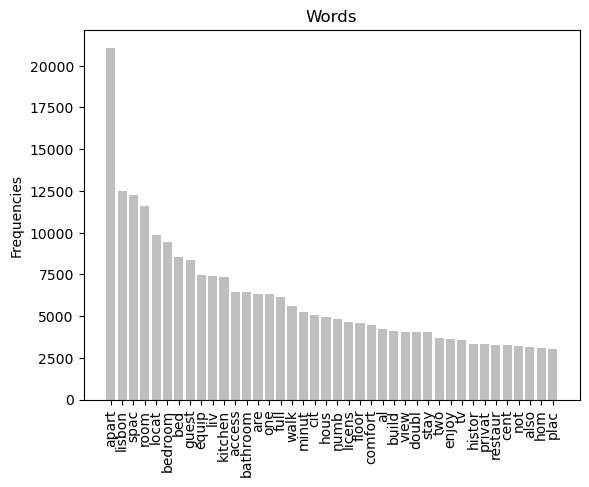

In [38]:
# create a list with all words in airbnb_df_train['description']
all_words_desc_proc = ' '.join(updates_desc).split()

# The frequency of each word
freq_desc_proc = pd.Series(all_words_desc_proc).value_counts()

# A bar plot with the top 35 words, for 'host_about' column
x_labels = freq_desc_proc.index[0:40]
values = freq_desc_proc[:40]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'grey')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

In [39]:
unique_words_desc_proc = sorted(set(all_words_desc_proc))
len(unique_words_desc_proc)

14733

In [40]:
len(all_words_desc)

1648726

<div class="alert alert-block alert-success">
Before the data preprocessing, we had 1.648.726 unique words after we reduced it to 14.733 words.

The list of unique words in the Description

In [41]:
print(unique_words_desc_proc)

['aanwezig', 'ab', 'aba', 'abad', 'abaiss', 'abaix', 'abaj', 'aban', 'abandon', 'abarrac', 'abast', 'abbaubar', 'abelh', 'abelheir', 'aben', 'abend', 'abenteur', 'aber', 'abert', 'abertur', 'abgehend', 'abgeht', 'abgeschliffen', 'abgeschlossen', 'abh', 'abholung', 'abid', 'abient', 'abil', 'abklappern', 'abl', 'abli', 'abnb', 'aboard', 'abod', 'abond', 'abonn', 'abordag', 'abou', 'abound', 'abr', 'abra', 'abrac', 'abrangent', 'abre', 'abrig', 'abril', 'abrir', 'abroad', 'abrunheir', 'abschalten', 'abseit', 'absenc', 'absens', 'absolu', 'absolut', 'absolutament', 'absorb', 'absorv', 'abster', 'abstract', 'absurd', 'abund', 'abus', 'abut', 'ac', 'aca', 'acab', 'acabamentosapart', 'acac', 'acad', 'academ', 'acapulc', 'acas', 'acc', 'acced', 'acceess', 'accent', 'accentu', 'accep', 'accept', 'acces', 'accesor', 'access', 'accessib', 'accessibilit', 'accessibl', 'accessor', 'accesst', 'accid', 'acclaim', 'acco', 'accom', 'accommod', 'accommodat', 'accomod', 'accompan', 'accomplish', 'accord

<div class="alert alert-block alert-danger"> 
We still have many words with the same meaning because we have different language like Lisbon:
'lisbo', 'lisboabo', 'lisboad', 'lisboaet', 'lisboan', 'lisboet', 'lisbom', 'lisbon', 'lisbonaccommod', 'lisboncmanag', 
'lisbonens', 'lisbonian', 'lisbonit', 'lisbonluxhom', 'lisbonn', 'lisbonnn'

**host_about**

In [42]:
updates_host = clean(airbnb_df_train['host_about'], lemmatize = True, stemmer = True)

100%|██████████| 12496/12496 [00:24<00:00, 509.07it/s]


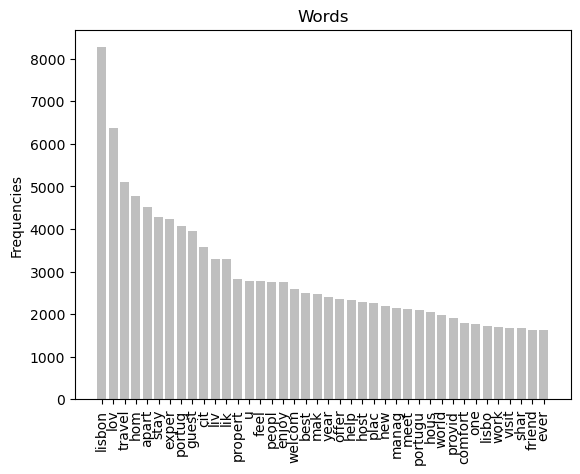

In [43]:
# create a list with all words in airbnb_df_train['host_about']
all_words_host_proc = ' '.join(updates_host).split()

# The frequency of each word
freq_host_proc = pd.Series(all_words_host_proc).value_counts()

# A bar plot with the top 35 words, for 'host_about' column
x_labels = freq_host_proc.index[0:40]
values = freq_host_proc[:40]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'grey')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

In [44]:
unique_words_host = sorted(set(all_words_host_proc))
len(unique_words_host)

10912

In [45]:
len(all_words_host)

931865

<div class="alert alert-block alert-success">
For hosts_about, before the data preprocessing, we had 931.865 unique words after we reduced it to 10.912 words.

Update our data frame with the new text preprocessed

In [46]:
airbnb_df_train = airbnb_df_train.drop(['word_count_description'], axis=1)
airbnb_df_train = airbnb_df_train.drop(['word_count_host_about'], axis=1)
airbnb_df_train.update(pd.DataFrame({"description": updates_desc}))
airbnb_df_train.update(pd.DataFrame({"host_about": updates_host}))
airbnb_df_train

,index,description,host_about,unlisted,language_description,language_host_about
0,1,shar mix room hostel shar bathroom locat right...,aloj local registr al,0,en,pt
1,2,espa fic pert parqu eduard vii saldanh estefan...,friend host tri alway around need anyth though...,1,pt,en
2,3,traf hous coz famili vill facil need relax com...,social person lik communic read travel lik cin...,1,en,en
3,4,apart charmos chi larg carm travess trindad es...,hell portugu lov meet peopl around word mayb o...,0,pt,en
4,5,jol appart en bordur mer min pie la plag vue m...,nous somm une famill avec deux enfant et an no...,0,fr,fr
...,...,...,...,...,...,...
12491,12492,cat bairr alto coz apart lisbon cit cent one t...,travel one favorit hobb alread visit sev count...,0,en,en
12492,12493,beaut locat heart lisbon histor cent near one ...,found travel enthusiast lik bnbird want connec...,0,en,en
12493,12494,enjoy breakfast sleek kitchen freestand knott ...,portug lov danc travel pleasur welcom amaz lisbon,0,en,en
12494,12495,terr eir cas camp rod rvor frut conv descans b...,famil gostam viaj receb amig pra camp sol sal,1,pt,pt


**Comments**

In [47]:
#updates_comments = clean(reviews_df_train['comments'], lemmatize = True, stemmer = True)

In [48]:
# Because it takes to long to run
# Exporting updates_comments to csv file
#with open('output/updates_comments.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerow(updates_comments)

In [49]:
# Import updates_comments from csv file
with open('output/updates_comments.csv', 'r') as f:
    reader = csv.reader(f)
    updates_comments = list(reader)[0]

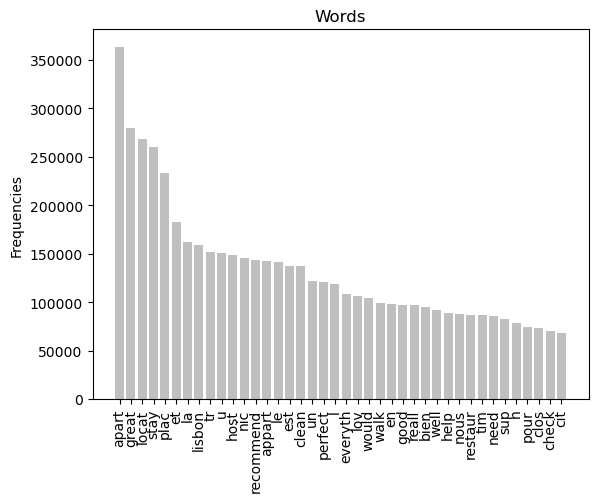

In [50]:
# create a list with all words in reviews_df_train['comments']
all_words_comments = ' '.join(updates_comments).split()

# The frequency of each word
freq_comments = pd.Series(all_words_comments).value_counts()

# A bar plot with the top 35 words, for 'comments' column
x_labels = freq_comments.index[0:40]
values = freq_comments[:40]
plt.bar(x_labels, values, align='center', alpha=0.5, color = 'grey')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

In [51]:
unique_words_comments = sorted(set(all_words_comments))
len(unique_words_comments)

111564

In [52]:
len(all_words_comments)

21570231

<div class="alert alert-block alert-success">
For comments, before the data preprocessing, we had 21.570.231 unique words after we reduced it to 111.564 words.

Update our data frame with the new text preprocessed

In [53]:
reviews_df_train.update(pd.DataFrame({"comments": updates_desc}))
reviews_df_train

,index,comments,word_count_comments,language
0,1,shar mix room hostel shar bathroom locat right...,28,en
1,1,espa fic pert parqu eduard vii saldanh estefan...,1,cy
2,1,traf hous coz famili vill facil need relax com...,261,en
3,1,apart charmos chi larg carm travess trindad es...,81,de
4,1,jol appart en bordur mer min pie la plag vue m...,27,en
...,...,...,...,...
721397,12494,"We had a good time, the apartment has a great ...",71,en
721398,12494,Great apartment in very central location. The ...,39,en
721399,12494,"We are Airbnb Super Hosts too, so trust me, Li...",35,en
721400,12494,We had a lovely stay at this apartment. Sofia ...,284,en


In [54]:
reviews_df_train['comments'] = reviews_df_train['comments'].astype('string')
reviews_df_train = reviews_df_train.dropna()

grouped = reviews_df_train.groupby(['index', 'language']).agg({'comments': 'count'})
grouped = grouped.reset_index()
final_grouped = grouped.groupby('index').agg({'language': 'nunique', 'comments': 'sum'})
final_grouped = final_grouped.reset_index()

# rename the columns to the desired names
final_grouped.columns = ['index', 'unique_languages_count', 'total_comments_count']
final_grouped

,index,unique_languages_count,total_comments_count
0,1,7,50
1,5,6,41
2,8,8,168
3,9,6,32
4,10,3,13
...,...,...,...
8461,12490,7,32
8462,12491,4,10
8463,12492,9,312
8464,12493,5,35


In [55]:
# English reviews

reviews_df_eng = reviews_df_train[(reviews_df_train['language']=='en')]

grouped_eng = reviews_df_eng.groupby(['index']).agg({'comments': ['count', ' '.join]})
grouped_eng.columns = ['_'.join(col).strip() for col in grouped_eng.columns.values]
grouped_eng = grouped_eng.reset_index()

# Rename the columns of the DataFrame
grouped_eng.columns = ['index', 'eng_comment_count', 'eng_reviews_merged']
grouped_eng

,index,eng_comment_count,eng_reviews_merged
0,1,30,shar mix room hostel shar bathroom locat right...
1,5,17,bom dia refurbish full equip tradit resident n...
2,8,145,desfrut son natur fic nest espa nic licens num...
3,9,16,oceanarium situat ocean front view atlant loca...
4,10,11,central hill apart compan apart cit cent ambit...
...,...,...,...
8294,12490,14,Excellent very well equiped apartment! Thank y...
8295,12491,7,I am so happy to found this accomodation near ...
8296,12492,212,We were very happy to find this place. The com...
8297,12493,27,"Nice place, nice location, easy communication!..."


In [56]:
merged_reviews = pd.merge(final_grouped, grouped_eng, on='index', how='left')
merged_reviews

,index,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
0,1,7,50,30.0,shar mix room hostel shar bathroom locat right...
1,5,6,41,17.0,bom dia refurbish full equip tradit resident n...
2,8,8,168,145.0,desfrut son natur fic nest espa nic licens num...
3,9,6,32,16.0,oceanarium situat ocean front view atlant loca...
4,10,3,13,11.0,central hill apart compan apart cit cent ambit...
...,...,...,...,...,...
8461,12490,7,32,14.0,Excellent very well equiped apartment! Thank y...
8462,12491,4,10,7.0,I am so happy to found this accomodation near ...
8463,12492,9,312,212.0,We were very happy to find this place. The com...
8464,12493,5,35,27.0,"Nice place, nice location, easy communication!..."


In [57]:
# Merging reviews to train_df
train_df = pd.merge(airbnb_df_train, merged_reviews, on='index', how='left')
train_df.head()

,index,description,host_about,unlisted,language_description,language_host_about,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
0,1,shar mix room hostel shar bathroom locat right...,aloj local registr al,0,en,pt,7.0,50.0,30.0,shar mix room hostel shar bathroom locat right...
1,2,espa fic pert parqu eduard vii saldanh estefan...,friend host tri alway around need anyth though...,1,pt,en,NaN,NaN,NaN,<NA>
2,3,traf hous coz famili vill facil need relax com...,social person lik communic read travel lik cin...,1,en,en,NaN,NaN,NaN,<NA>
3,4,apart charmos chi larg carm travess trindad es...,hell portugu lov meet peopl around word mayb o...,0,pt,en,NaN,NaN,NaN,<NA>
4,5,jol appart en bordur mer min pie la plag vue m...,nous somm une famill avec deux enfant et an no...,0,fr,fr,6.0,41.0,17.0,bom dia refurbish full equip tradit resident n...


In [58]:
# Scaling selected columns with MinMaxScaler
scaler = MinMaxScaler()
cols_to_scale = ['unique_languages_count', 'total_comments_count', 'eng_comment_count']
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])

train_df.head()

,index,description,host_about,unlisted,language_description,language_host_about,unique_languages_count,total_comments_count,eng_comment_count,eng_reviews_merged
0,1,shar mix room hostel shar bathroom locat right...,aloj local registr al,0,en,pt,0.222222,0.041809,0.040166,shar mix room hostel shar bathroom locat right...
1,2,espa fic pert parqu eduard vii saldanh estefan...,friend host tri alway around need anyth though...,1,pt,en,NaN,NaN,NaN,<NA>
2,3,traf hous coz famili vill facil need relax com...,social person lik communic read travel lik cin...,1,en,en,NaN,NaN,NaN,<NA>
3,4,apart charmos chi larg carm travess trindad es...,hell portugu lov meet peopl around word mayb o...,0,pt,en,NaN,NaN,NaN,<NA>
4,5,jol appart en bordur mer min pie la plag vue m...,nous somm une famill avec deux enfant et an no...,0,fr,fr,0.185185,0.034130,0.022161,bom dia refurbish full equip tradit resident n...


In [59]:
train_df['eng_reviews_merged'].fillna(value = '', inplace = True)

<hr>
<a class="anchor" id="training_features">
    
# 4. Define training features
    
</a>

Split the dataset into train and validation and maintain the original format

In [60]:
train = train_df.sample(frac=0.8, random_state=1)
validation = train_df.drop(train.index)

Define the independent variable

In [61]:
x_train_1 = train['description']

In [62]:
x_train_2 = train['eng_reviews_merged']
x_train_2

9375     Loved my stay in Lisbon!<br/><br/>Highly recom...
9534     Lovely apt with a beautiful interior design in...
813      Really cozy flat in a nice area of the city! R...
11245    Absolutely fantastic apartment, our hands-down...
1436     Nice small apartment near to the center! Very ...
                               ...                        
9162                                                      
7186                                                      
7820                                                      
3007     Sparkling clean apartment ..modern kitchen wit...
7225     We were very happy with renting a room here._x...
Name: eng_reviews_merged, Length: 9997, dtype: string

In [63]:
x_val_1 = validation['description']
x_val_1

0        shar mix room hostel shar bathroom locat right...
2        traf hous coz famili vill facil need relax com...
15       supr well locat histor build design famous pom...
18       lov cas sobral locat littl villag sobral minut...
20       import respons covid propert extend clean disi...
                               ...                        
12470    appart front litl beach cent casca histor stre...
12476    proud offer modern apart quiet resident are sh...
12479    enjoy peac getaway right famous guinch beach s...
12489    locat telheir studi accommod peopl well equip ...
12491    cat bairr alto coz apart lisbon cit cent one t...
Name: description, Length: 2499, dtype: object

In [64]:
x_val_2 = validation['eng_reviews_merged']
x_val_2

0        shar mix room hostel shar bathroom locat right...
2                                                         
15       larg two bedroom apart near cit cent metr stat...
18       journey begin moment decid go giv first step c...
20                                                        
                               ...                        
12470                                                     
12476    Great place to stay. The apartment is very new...
12479    Peter was an amazing host and the place was ex...
12489    Excellent very well equiped apartment! Thank y...
12491    We were very happy to find this place. The com...
Name: eng_reviews_merged, Length: 2499, dtype: string

Define labels

In [65]:
y_train = np.array(train['unlisted'])
y_train

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [66]:
len(y_train)

9997

In [67]:
# get the unique values and their counts
unique_values, counts = np.unique(y_train, return_counts=True)

# calculate the percentage of each unique value
total = len(y_train)
percentages = counts / total * 100

# print the unique values, their counts, and their percentages
for i in range(len(unique_values)):
    print(f"{unique_values[i]} occurs {counts[i]} times ({percentages[i]:.2f}%)")

0 occurs 7213 times (72.15%)
1 occurs 2784 times (27.85%)


In [68]:
y_val = np.array(validation['unlisted'])
y_val

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [69]:
# get the unique values and their counts
unique_values, counts = np.unique(y_val, return_counts=True)

# calculate the percentage of each unique value
total = len(y_val)
percentages = counts / total * 100

# print the unique values, their counts, and their percentages
for i in range(len(unique_values)):
    print(f"{unique_values[i]} occurs {counts[i]} times ({percentages[i]:.2f}%)")

0 occurs 1820 times (72.83%)
1 occurs 679 times (27.17%)


<div class="alert alert-block alert-danger"> 
The train and validation are both unbalanced but with the same proportion.

<hr>
<a class="anchor" id="bow">
    
## 4.1. Bag of Words (Bow)
    
</a>

In [70]:
# With the Bag of words, each word is a feature, with 1 and 0

Create BoW from train corpus

In [71]:
bow_desc = CountVectorizer(binary=True)     
bow_reviews = CountVectorizer(binary=True, max_features=1000) 

X_train_1_bow = bow_desc.fit_transform(x_train_1)
X_train_1_bow

X_train_2_bow = bow_reviews.fit_transform(x_train_2)
X_train_2_bow

print(X_train_1_bow.shape, X_train_2_bow.shape)

(9997, 13509) (9997, 1000)


In [72]:
n1 = X_train_1_bow.shape[1]
n2 = X_train_2_bow.shape[1]
n_additional = len(cols_to_scale)

X_train_ext = np.zeros((X_train_1_bow.shape[0], n1 + n2 + n_additional))


X_train_ext[:, :n1] = X_train_1_bow.toarray() 
X_train_ext[:, n1:n1+n2] = X_train_2_bow.toarray()
X_train_ext[:, n1+n2:] = train[cols_to_scale].values

X_train_ext_bow = np.nan_to_num(X_train_ext, nan=0) 

X_train_ext_bow.shape

(9997, 14512)

For validation

In [73]:
X_val_1_bow = bow_desc.transform(x_val_1)
X_val_2_bow = bow_reviews.transform(x_val_2)                            
n1 = X_val_1_bow.shape[1]
n2 = X_val_2_bow.shape[1]
n_additional = len(cols_to_scale)

X_val_ext = np.zeros((X_val_1_bow.shape[0], n1 + n2 + n_additional))
X_val_ext[:, :n1] = X_val_1_bow.toarray()      
X_val_ext[:, n1:n1+n2] = X_val_2_bow.toarray() 
X_val_ext[:, n1+n2:] = validation[cols_to_scale].values   

X_val_ext_bow = np.nan_to_num(X_val_ext, nan=0)                                    

y_val = np.array(validation['unlisted'])

print(X_val_ext_bow.shape, y_val.shape)

(2499, 14512) (2499,)


<hr>
<a class="anchor" id="tf-idf">
    
## 4.2. TF_IDF
    
</a>

<hr>
<a class="anchor" id="tf-idf-1gram">
    
### 4.2.1 TF_IDF - 1-Gram
    
</a>

In [74]:
# In Bow all the words have the same importance, 
# But the TF-IDF, will penalize words that appear several times each word will have a weight
# Sould be a little more robuts than Bow

For Train Corpus

In [75]:
tfidf_desc = TfidfVectorizer(max_df=0.8)
tfidf_reviews = TfidfVectorizer(max_features=1000)


X_train_1_tfidf = tfidf_desc.fit_transform(x_train_1)
X_train_1_tfidf

X_train_2_tfidf = tfidf_reviews.fit_transform(x_train_2)
X_train_2_tfidf

print(X_train_1_tfidf.shape, X_train_2_tfidf.shape)

(9997, 13509) (9997, 1000)


In [76]:
n1 = X_train_1_tfidf.shape[1]
n2 = X_train_2_tfidf.shape[1]
n_additional = len(cols_to_scale)

X_train_ext_tfidf = np.zeros((X_train_1_tfidf.shape[0], n1 + n2 + n_additional))


X_train_ext_tfidf[:, :n1] = X_train_1_tfidf.toarray() 
X_train_ext_tfidf[:, n1:n1+n2] = X_train_2_tfidf.toarray() 
X_train_ext_tfidf[:, n1+n2:] = train[cols_to_scale].values

X_train_ext_tfidf = np.nan_to_num(X_train_ext_tfidf, nan=0)

X_train_ext_tfidf.shape

(9997, 14512)

For Validation Corpus

In [77]:
X_val_1_tfidf = tfidf_desc.transform(x_val_1)
X_val_2_tfidf = tfidf_reviews.transform(x_val_2)                            
n1 = X_val_1_tfidf.shape[1]
n2 = X_val_2_tfidf.shape[1]
n_additional = len(cols_to_scale)

X_val_ext_tfidf = np.zeros((X_val_1_tfidf.shape[0], n1 + n2 + n_additional))
X_val_ext_tfidf[:, :n1] = X_val_1_tfidf.toarray()      
X_val_ext_tfidf[:, n1:n1+n2] = X_val_2_tfidf.toarray() 
X_val_ext_tfidf[:, n1+n2:] = validation[cols_to_scale].values   

X_val_ext_tfidf = np.nan_to_num(X_val_ext_tfidf, nan=0)                                    


print(X_val_ext_tfidf.shape, y_val.shape)

(2499, 14512) (2499,)


<hr>
<a class="anchor" id="tf-idf-2gram">
    
### 4.2.2. TF_IDF - 2-Gram
    
</a>

For Train Corpus

In [78]:
tfidf_desc_2g = TfidfVectorizer(max_df=0.8, ngram_range=(1, 2))
tfidf_reviews_2g = TfidfVectorizer(max_features=1000)


X_train_1_tfidf_2g = tfidf_desc_2g.fit_transform(x_train_1)
X_train_1_tfidf_2g

X_train_2_tfidf_2g = tfidf_reviews_2g.fit_transform(x_train_2)
X_train_2_tfidf_2g

print(X_train_1_tfidf_2g.shape, X_train_2_tfidf_2g.shape)

(9997, 208776) (9997, 1000)


In [79]:
n1_2g = X_train_1_tfidf_2g.shape[1]
n2_2g = X_train_2_tfidf_2g.shape[1]
n_additional = len(cols_to_scale)

X_train_ext_tfidf_2g = np.zeros((X_train_1_tfidf_2g.shape[0], n1_2g + n2_2g + n_additional))


X_train_ext_tfidf_2g[:, :n1_2g] = X_train_1_tfidf_2g.toarray() 
X_train_ext_tfidf_2g[:, n1_2g:n1_2g+n2_2g] = X_train_2_tfidf_2g.toarray() 
X_train_ext_tfidf_2g[:, n1_2g+n2_2g:] = train[cols_to_scale].values

X_train_ext_tfidf_2g = np.nan_to_num(X_train_ext_tfidf_2g, nan=0)

X_train_ext_tfidf_2g.shape

(9997, 209779)

For Validation Corpus

In [80]:
X_val_1_tfidf_2g = tfidf_desc_2g.transform(x_val_1)
X_val_2_tfidf_2g = tfidf_reviews_2g.transform(x_val_2)                            
n1_2g = X_val_1_tfidf_2g.shape[1]
n2_2g = X_val_2_tfidf_2g.shape[1]
n_additional = len(cols_to_scale)

X_val_ext_tfidf_2g = np.zeros((X_val_1_tfidf_2g.shape[0], n1_2g + n2_2g + n_additional))
X_val_ext_tfidf_2g[:, :n1_2g] = X_val_1_tfidf_2g.toarray()      
X_val_ext_tfidf_2g[:, n1_2g:n1_2g+n2_2g] = X_val_2_tfidf_2g.toarray() 
X_val_ext_tfidf_2g[:, n1_2g+n2_2g:] = validation[cols_to_scale].values   

X_val_ext_tfidf_2g = np.nan_to_num(X_val_ext_tfidf_2g, nan=0)                                    


print(X_val_ext_tfidf_2g.shape, y_val.shape)

(2499, 209779) (2499,)


<hr>
<a class="anchor" id="classificationmodels">
    
# 5. Classification Models
    
</a>

In [81]:
labels = {"Unlisted":1, "Listed":0}

In [82]:
# Funtion to show results
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

<hr>
<a class="anchor" id="KNN">
    
## 5.1. KNeighborsClassifier
    
</a>

In [83]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

<hr>
<a class="anchor" id="KNN_bow">
    
### 5.1.1 Bow
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.82      0.86      2008
      Listed       0.47      0.65      0.55       491

    accuracy                           0.79      2499
   macro avg       0.69      0.74      0.70      2499
weighted avg       0.82      0.79      0.80      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


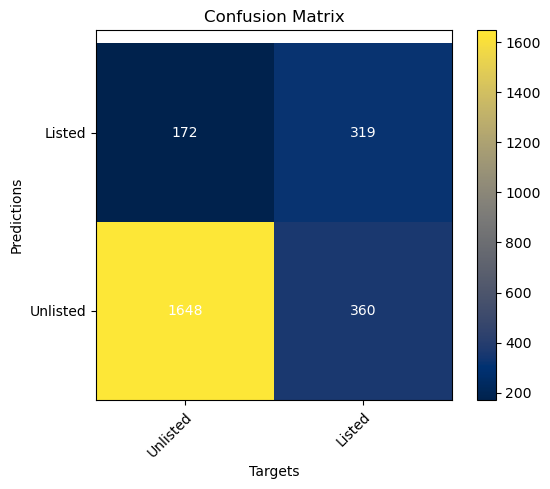

In [84]:
modelknn.fit(X_train_1_bow,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_1_bow)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       1.00      0.73      0.84      2499
      Listed       0.00      0.00      0.00         0

    accuracy                           0.73      2499
   macro avg       0.50      0.36      0.42      2499
weighted avg       1.00      0.73      0.84      2499



C:\Users\katxi\anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\katxi\anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\katxi\anaconda3_\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarni

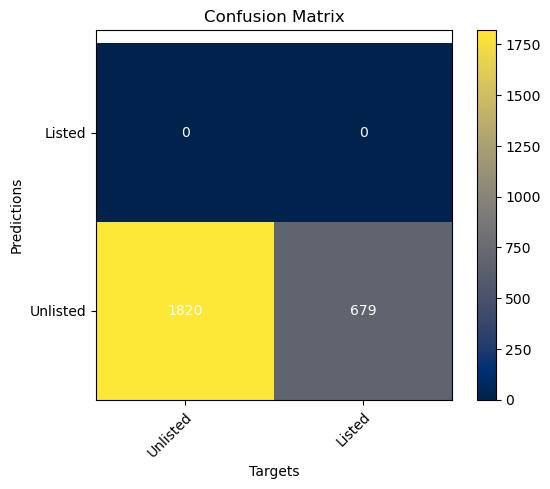

In [85]:
modelknn.fit(X_train_2_bow,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_2_bow)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.92      0.92      0.92      1817
      Listed       0.78      0.77      0.78       682

    accuracy                           0.88      2499
   macro avg       0.85      0.85      0.85      2499
weighted avg       0.88      0.88      0.88      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


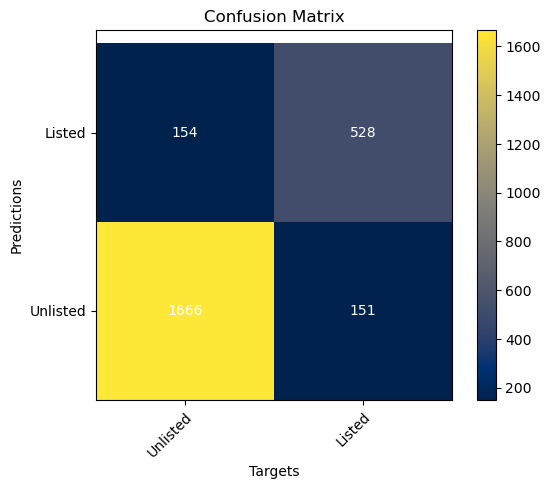

In [86]:
modelknn.fit(X_train_ext_bow,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_ext_bow)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="KNN_tfidf-1gram">
    
### 5.1.2 TF_IDF 1-Gram
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.92      0.82      0.87      2054
      Listed       0.45      0.69      0.55       445

    accuracy                           0.80      2499
   macro avg       0.69      0.75      0.71      2499
weighted avg       0.84      0.80      0.81      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


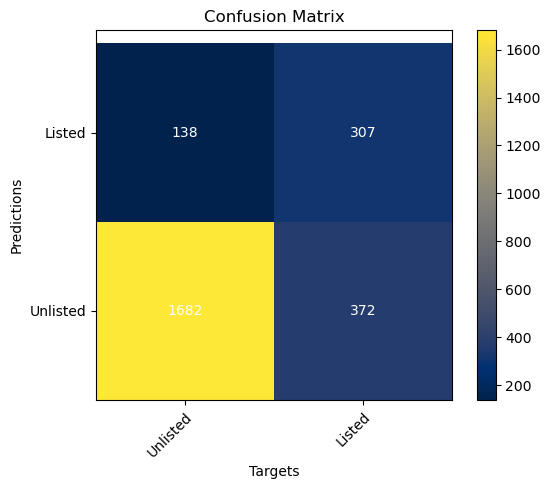

In [87]:
modelknn.fit(X_train_1_tfidf,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_1_tfidf)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       1.00      0.73      0.84      2496
      Listed       0.00      0.33      0.00         3

    accuracy                           0.73      2499
   macro avg       0.50      0.53      0.42      2499
weighted avg       1.00      0.73      0.84      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


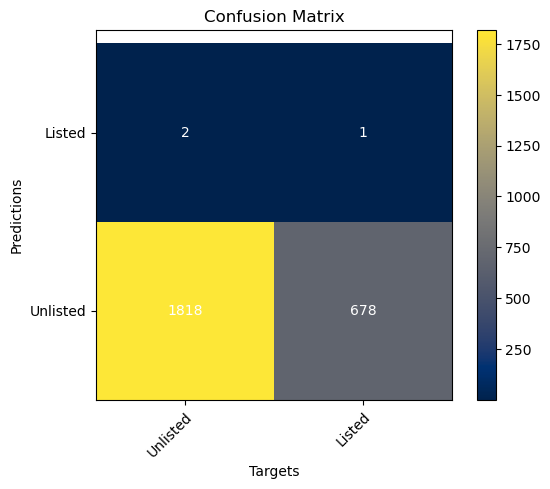

In [88]:
modelknn.fit(X_train_2_tfidf,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_2_tfidf)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.91      0.92      1870
      Listed       0.74      0.80      0.77       629

    accuracy                           0.88      2499
   macro avg       0.84      0.85      0.84      2499
weighted avg       0.88      0.88      0.88      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


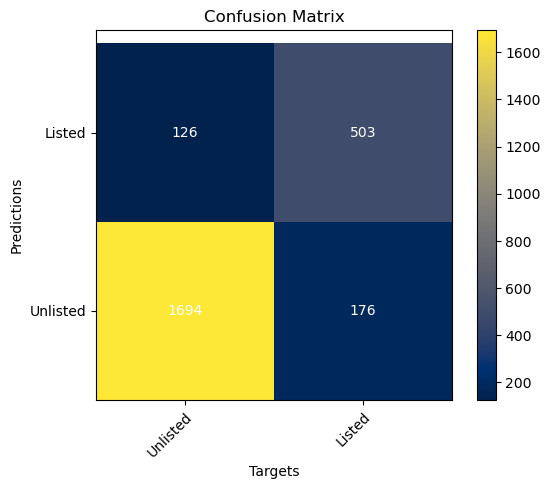

In [89]:
modelknn.fit(X_train_ext_tfidf,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_ext_tfidf)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="KNN_tfidf-2gram">
    
### 5.1.3 TF_IDF 2-Gram
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.82      0.87      2064
      Listed       0.45      0.70      0.55       435

    accuracy                           0.80      2499
   macro avg       0.69      0.76      0.71      2499
weighted avg       0.85      0.80      0.81      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


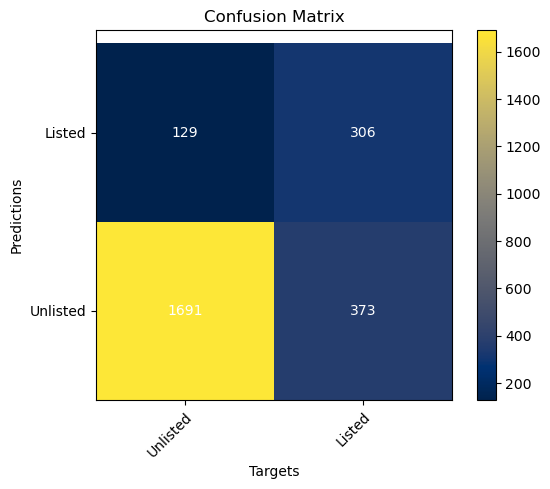

In [90]:
modelknn.fit(X_train_1_tfidf_2g,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_1_tfidf_2g)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       1.00      0.73      0.84      2496
      Listed       0.00      0.33      0.00         3

    accuracy                           0.73      2499
   macro avg       0.50      0.53      0.42      2499
weighted avg       1.00      0.73      0.84      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


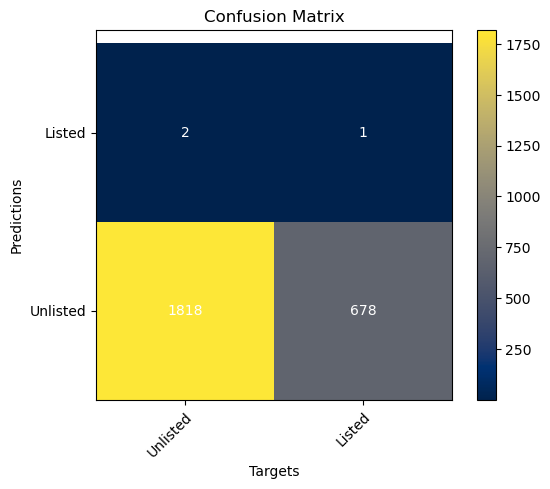

In [91]:
modelknn.fit(X_train_2_tfidf_2g,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_2_tfidf_2g)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.94      0.88      0.91      1930
      Listed       0.67      0.80      0.73       569

    accuracy                           0.87      2499
   macro avg       0.81      0.84      0.82      2499
weighted avg       0.88      0.87      0.87      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


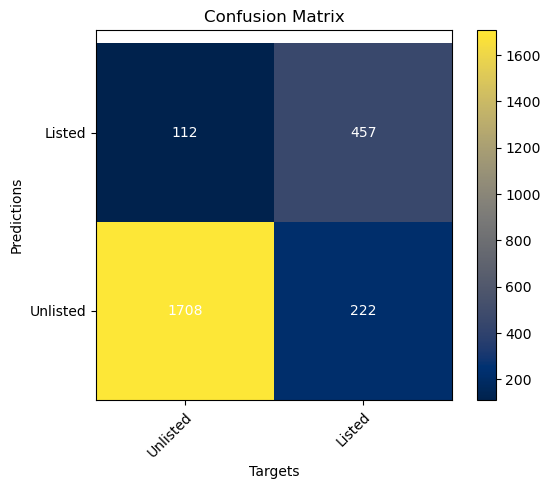

In [92]:
modelknn.fit(X_train_ext_tfidf_2g,y_train)

# Prediction
y_pred_knn = modelknn.predict(X_val_ext_tfidf_2g)

# Evaluation
print(classification_report(y_pred_knn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_knn, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest">
    
## 5.2. Random Forest
    
</a>

In [93]:
model_forest = RandomForestClassifier(n_estimators=100, 
                                      class_weight={0: 0.7, 1: 0.3}, 
                                      random_state=42)

<hr>
<a class="anchor" id="randomforest_bow">
    
### 5.2.1 Bow
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.97      0.80      0.88      2223
      Listed       0.33      0.82      0.48       276

    accuracy                           0.80      2499
   macro avg       0.65      0.81      0.68      2499
weighted avg       0.90      0.80      0.83      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


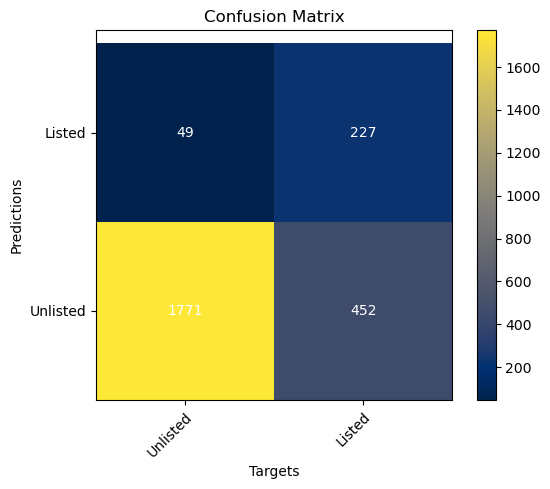

In [94]:
model_forest.fit(X_train_1_bow,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_1_bow)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.94      0.90      1670
      Listed       0.85      0.69      0.76       829

    accuracy                           0.86      2499
   macro avg       0.85      0.82      0.83      2499
weighted avg       0.86      0.86      0.85      2499



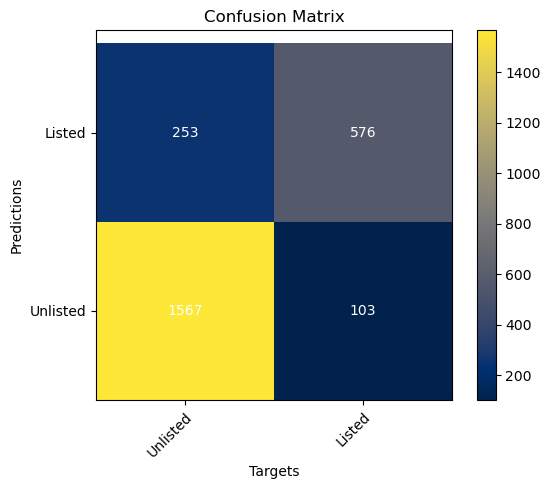

In [137]:
model_forest.fit(X_train_2_bow,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_2_bow)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1783
      Listed       0.82      0.78      0.80       716

    accuracy                           0.89      2499
   macro avg       0.87      0.86      0.86      2499
weighted avg       0.89      0.89      0.89      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


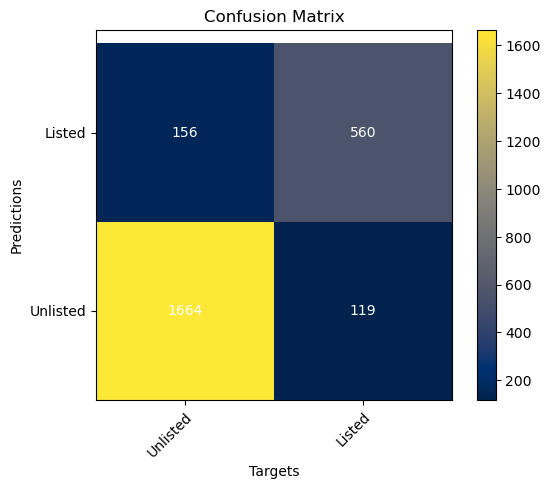

In [96]:
model_forest.fit(X_train_ext_bow, y_train)

# Predicting
y_pred_forest = model_forest.predict(X_val_ext_bow)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest_tfidf-1gram">
    
### 5.2.2 TF_IDF 1-Gram
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.97      0.80      0.88      2212
      Listed       0.35      0.82      0.49       287

    accuracy                           0.80      2499
   macro avg       0.66      0.81      0.68      2499
weighted avg       0.90      0.80      0.83      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


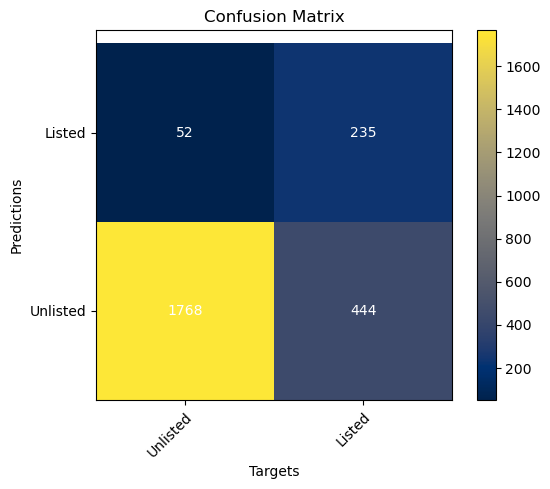

In [97]:
model_forest.fit(X_train_1_tfidf,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_1_tfidf)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.94      0.90      1670
      Listed       0.85      0.69      0.76       829

    accuracy                           0.86      2499
   macro avg       0.85      0.82      0.83      2499
weighted avg       0.86      0.86      0.85      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


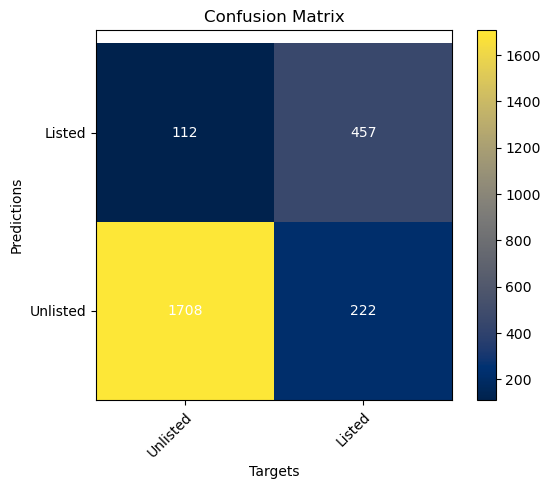

In [98]:
model_forest.fit(X_train_2_tfidf,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_2_tfidf)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1781
      Listed       0.83      0.78      0.80       718

    accuracy                           0.89      2499
   macro avg       0.87      0.86      0.86      2499
weighted avg       0.89      0.89      0.89      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


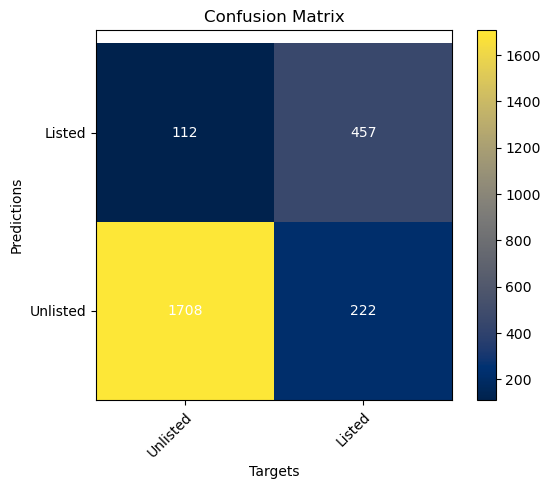

In [99]:
model_forest.fit(X_train_ext_tfidf,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_ext_tfidf)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="randomforest_tfidf-2gram">
    
### 5.2.3 TF_IDF 2-Gram
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.97      0.80      0.88      2208
      Listed       0.35      0.81      0.49       291

    accuracy                           0.80      2499
   macro avg       0.66      0.81      0.68      2499
weighted avg       0.90      0.80      0.83      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


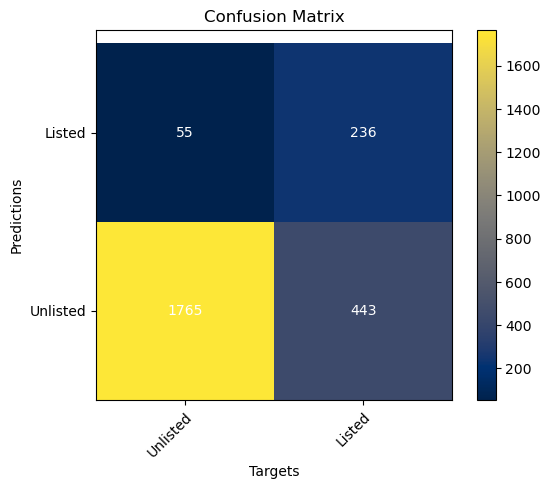

In [100]:
model_forest.fit(X_train_1_tfidf_2g,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_1_tfidf_2g)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.94      0.90      1670
      Listed       0.85      0.69      0.76       829

    accuracy                           0.86      2499
   macro avg       0.85      0.82      0.83      2499
weighted avg       0.86      0.86      0.85      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


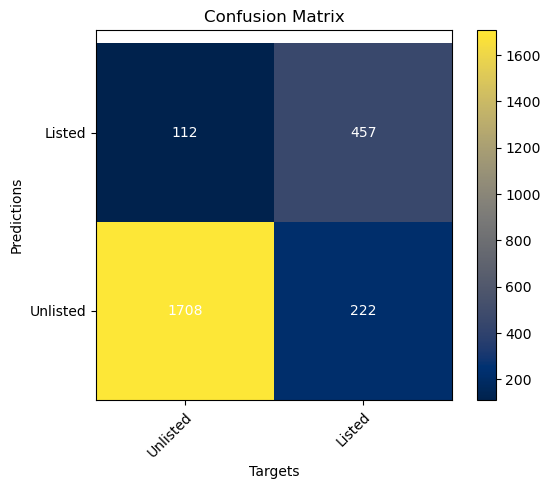

In [101]:
model_forest.fit(X_train_2_tfidf_2g,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_2_tfidf_2g)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.91      0.93      0.92      1773
      Listed       0.83      0.77      0.80       726

    accuracy                           0.89      2499
   macro avg       0.87      0.85      0.86      2499
weighted avg       0.89      0.89      0.89      2499



C:\Users\katxi\AppData\Local\Temp\ipykernel_38144\343988510.py:40: UserWarning: Attempting to set identical bottom == top == 1.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


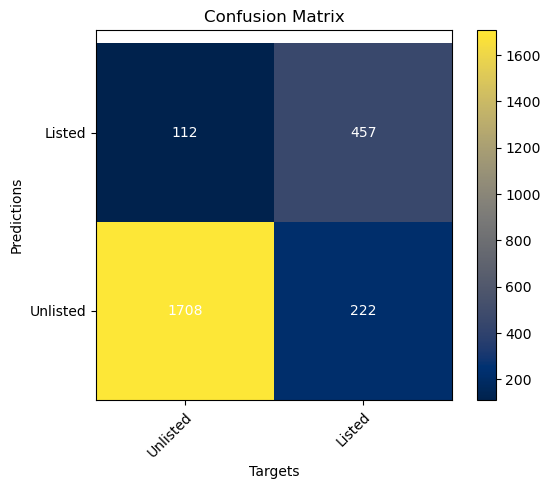

In [102]:
model_forest.fit(X_train_ext_tfidf_2g,y_train)

# Prediction
y_pred_forest = model_forest.predict(X_val_ext_tfidf_2g)

# Evaluation
print(classification_report(y_pred_forest, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_forest, y_val), labels.keys())

<hr>
<a class="anchor" id="naivebayes">
    
## 5.3. Naive Bayes
    
</a>

In [120]:
model_nb = GaussianNB()

In [140]:
X_train_1_bow_array = X_train_1_bow.toarray()
X_train_2_bow_array = X_train_2_bow.toarray()
#X_train_ext_bow_array = X_train_ext_bow.toarray()
X_val_1_bow_array= X_val_1_bow.toarray()
X_val_2_bow_array= X_val_2_bow.toarray()
#X_val_ext_bow_array = X_val_ext_bow.toarray()

<hr>
<a class="anchor" id="nb_bow">
    
### 5.3.1 Bow
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.47      0.85      0.60      1004
      Listed       0.77      0.35      0.48      1495

    accuracy                           0.55      2499
   macro avg       0.62      0.60      0.54      2499
weighted avg       0.65      0.55      0.53      2499



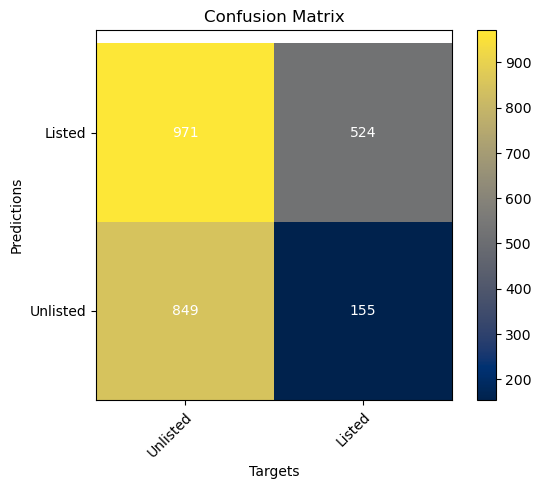

In [123]:
model_nb.fit(X_train_1_bow_array,y_train)

# Prediction
y_pred_nb = model_nb.predict(X_val_1_bow_array)

# Evaluation
print(classification_report(y_pred_nb, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_nb, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       0.71      0.95      0.81      1375
      Listed       0.89      0.54      0.67      1124

    accuracy                           0.76      2499
   macro avg       0.80      0.74      0.74      2499
weighted avg       0.79      0.76      0.75      2499



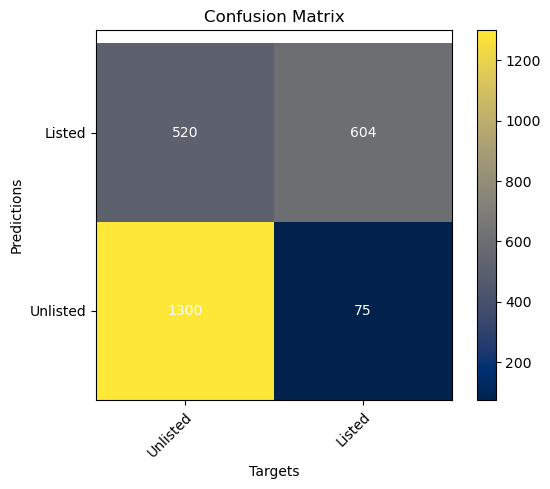

In [142]:
model_nb.fit(X_train_2_bow_array,y_train)

# Prediction
y_pred_nb = model_nb.predict(X_val_2_bow_array)

# Evaluation
print(classification_report(y_pred_nb, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_nb, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.47      0.85      0.60      1004
      Listed       0.77      0.35      0.48      1495

    accuracy                           0.55      2499
   macro avg       0.62      0.60      0.54      2499
weighted avg       0.65      0.55      0.53      2499



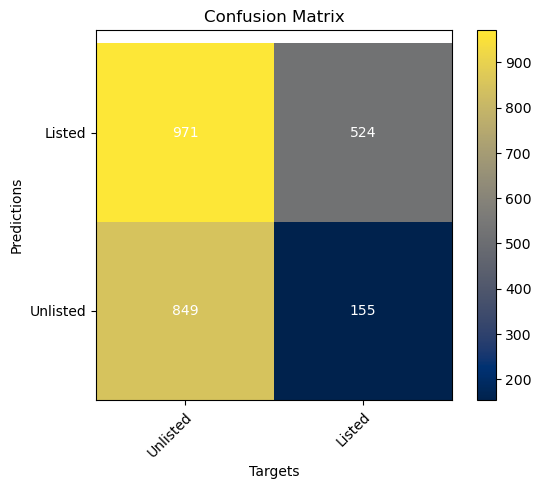

In [141]:
model_nb.fit(X_train_ext_bow, y_train)

# Predicting
y_pred_nb = model_nb.predict(X_val_ext_bow)

# Evaluation
print(classification_report(y_pred_nb, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_nb, y_val), labels.keys())

<hr>
<a class="anchor" id="logisticregression">
    
## 5.4. Logistic Regression
    
</a>

In [129]:
model_lr = LogisticRegression()

<hr>
<a class="anchor" id="lr_bow">
    
### 5.4.1 Bow
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.82      0.84      1915
      Listed       0.49      0.57      0.53       584

    accuracy                           0.76      2499
   macro avg       0.68      0.70      0.68      2499
weighted avg       0.78      0.76      0.77      2499



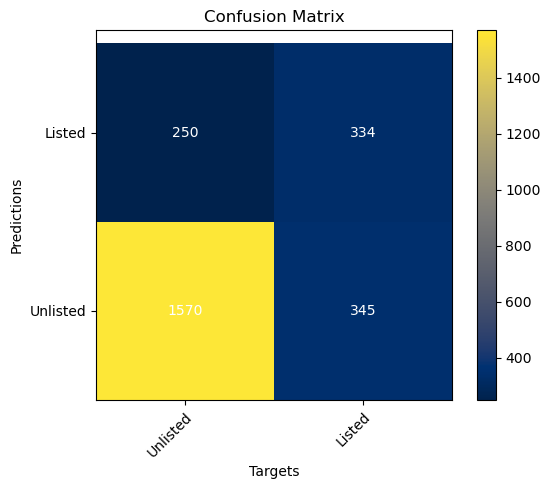

In [130]:
model_lr.fit(X_train_1_bow_array,y_train)

# Prediction
y_pred_lr = model_lr.predict(X_val_1_bow_array)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       0.81      0.94      0.87      1576
      Listed       0.86      0.63      0.73       923

    accuracy                           0.83      2499
   macro avg       0.84      0.79      0.80      2499
weighted avg       0.83      0.83      0.82      2499



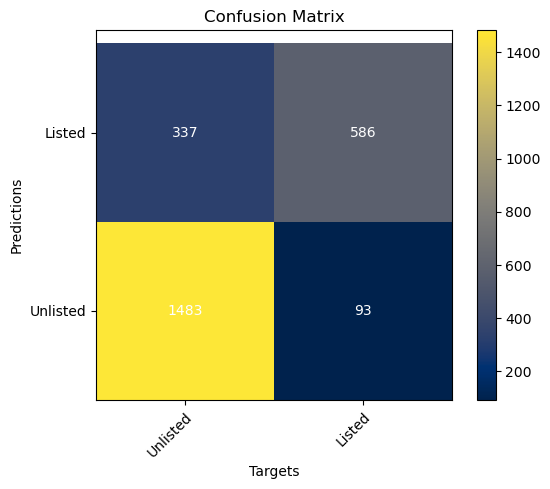

In [145]:
model_lr.fit(X_train_2_bow_array,y_train)

# Prediction
y_pred_lr = model_lr.predict(X_val_2_bow_array)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.88      0.90      0.89      1772
      Listed       0.75      0.70      0.72       727

    accuracy                           0.84      2499
   macro avg       0.81      0.80      0.81      2499
weighted avg       0.84      0.84      0.84      2499



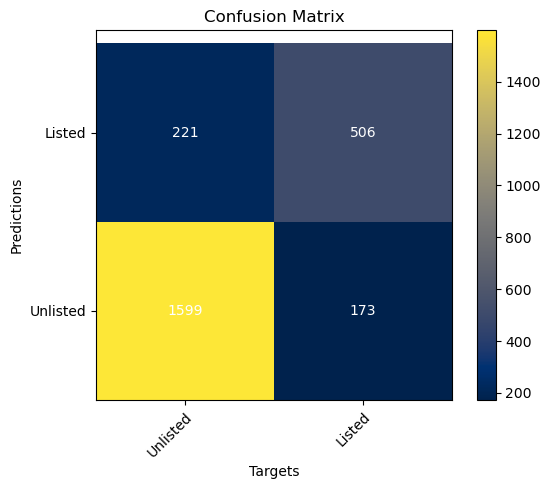

In [144]:
model_lr.fit(X_train_ext_bow, y_train)

# Predicting
y_pred_lr = model_lr.predict(X_val_ext_bow)

# Evaluation
print(classification_report(y_pred_lr, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

<hr>
<a class="anchor" id="nn">
    
## 5.5. Neural Networks
    
</a>

In [134]:
model_nn = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)

<hr>
<a class="anchor" id="nn_bow">
    
### 5.5.1 Bow
    
</a>

Based on **Description**:

              precision    recall  f1-score   support

    Unlisted       0.84      0.83      0.83      1853
      Listed       0.53      0.55      0.54       646

    accuracy                           0.76      2499
   macro avg       0.68      0.69      0.69      2499
weighted avg       0.76      0.76      0.76      2499



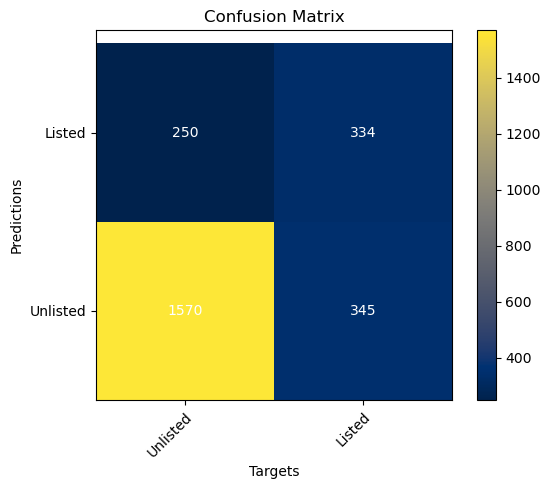

In [135]:
model_nn.fit(X_train_1_bow_array,y_train)

# Prediction
y_pred_nn = model_nn.predict(X_val_1_bow_array)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_lr, y_val), labels.keys())

Based on **Comments**:

              precision    recall  f1-score   support

    Unlisted       0.86      0.94      0.90      1665
      Listed       0.85      0.69      0.76       834

    accuracy                           0.86      2499
   macro avg       0.86      0.82      0.83      2499
weighted avg       0.86      0.86      0.85      2499



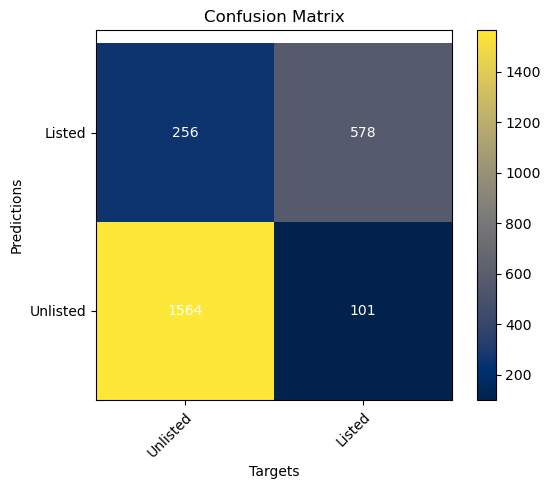

In [146]:
model_nn.fit(X_train_2_bow_array,y_train)

# Prediction
y_pred_nn = model_nn.predict(X_val_2_bow_array)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))

plot_cm(confusion_matrix(y_pred_nn, y_val), labels.keys())

Based on **Description and Comments**:

              precision    recall  f1-score   support

    Unlisted       0.93      0.89      0.91      1902
      Listed       0.68      0.77      0.72       597

    accuracy                           0.86      2499
   macro avg       0.80      0.83      0.81      2499
weighted avg       0.87      0.86      0.86      2499



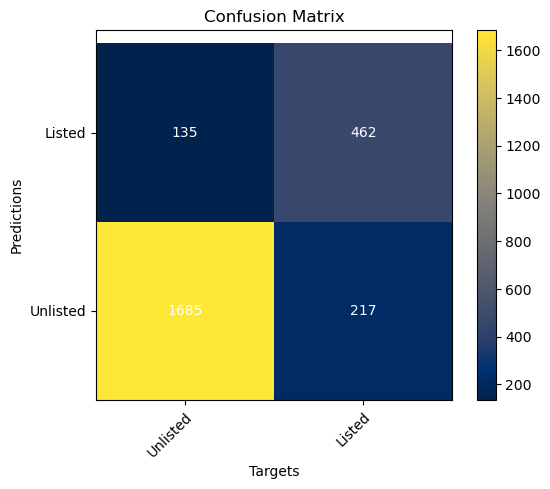

In [147]:
model_nn.fit(X_train_ext_bow, y_train)

# Predicting
y_pred_nn = model_nn.predict(X_val_ext_bow)

# Evaluation
print(classification_report(y_pred_nn, y_val, target_names = labels.keys()))
plot_cm(confusion_matrix(y_pred_nn, y_val), labels.keys())

<hr>
<a class="anchor" id="gridsearch">
    
## 5.6. Grid Search
    
</a>

In [149]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}

In [151]:
clf = GridSearchCV(model_nn, parameter_space)

In [152]:
clf.fit(X_train_ext_bow, y_train)

GridSearchCV(estimator=MLPClassifier(activation='logistic',
                                     hidden_layer_sizes=(2, 2),
                                     random_state=1),
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(50, 50, 50), (100,)],
                         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
                         'solver': ['sgd', 'adam']})

In [153]:
clf.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'solver': 'sgd'}

In [154]:
final_model = clf.best_estimator_.fit(X_train_ext_bow, y_train)
print('Train:', final_model.score(X_train_ext_bow, y_train))
print('Test:', final_model.score(X_val_ext_bow, y_val))

Train: 0.9385815744723417
Test: 0.8739495798319328


In [155]:
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'sgd'}
------------------------------------------------------------------------------------------------------------------------
0.865 (+/-0.008) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.0001, 'solver': 'sgd'}
0.830 (+/-0.005) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.0001, 'solver': 'adam'}
0.833 (+/-0.006) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.001, 'solver': 'sgd'}
0.841 (+/-0.008) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.832 (+/-0.009) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate_init': 0.01, 'solver': 'sgd'}
0.

In [ ]:
###
### MAKING PREDICTIONS ON TEST (UNSEEN) DATA
###

In [6]:
### PROCESSING TEST DATA

# Read .xlsx 
airbnb_df_test = pd.read_excel('Project Corpora/test.xlsx')
airbnb_df_test.to_csv('output/test.csv', index=False)

# Savw to .csv to process later in chunks
reviews_df_test = pd.read_excel('Project Corpora/test_reviews.xlsx')
reviews_df_test.to_csv('output/test_reviews.csv', index=False)

In [7]:
### TEST DATA >>> DETECTING LANGUAGES

In [8]:
# Detecting languages in the TEST dataset >>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/test.csv'
destination_file = 'output/test_with_language.csv'

chunk_size = 500
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['description'] = chunk['description'].str.replace('<br/>', '')
    chunk['description'] = chunk['description'].str.replace('x000D', '')
    chunk['description_language'] = chunk['description'].apply(detect_language)
    
    chunk['host_about'] = chunk['host_about'].str.replace('<br/>', '')
    chunk['host_about'] = chunk['host_about'].str.replace('x000D', '')
    chunk['host_about_language'] = chunk['host_about'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

3it [00:07,  2.38s/it]


In [9]:
# Detecting languages in the TEST Reviews dataset >>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/test_reviews.csv'
destination_file = 'output/test_reviews_with_language.csv'

chunk_size = 500
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['comments'] = chunk['comments'].str.replace('<br/>', '')
    chunk['comments'] = chunk['comments'].str.replace('x000D', '')
    chunk['comments_language'] = chunk['comments'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

162it [02:29,  1.08it/s]


In [ ]:
### TEST DATA >>> REMOVING HTML TAGS

In [13]:
airbnb_language_df = pd.read_csv('output/test_with_language.csv')
reviews_languages_df = pd.read_csv('output/test_reviews_with_language.csv')

# Applying the function above to remove HTML tags 
clean_airbnb_df = remove_HTML_tags(airbnb_language_df, 'description')
clean_airbnb_df = remove_HTML_tags(clean_airbnb_df,'host_about')

clean_reviews_df = remove_HTML_tags(reviews_languages_df,'comments')

In [ ]:
### TEST DATA >>> TRANSLATION

In [14]:
## Translating 'description' column, creating a new column 'description_english'

# Taking descriptions values and their detected languages
descriptions = clean_airbnb_df.description
description_languages = clean_airbnb_df.description_language

# Generating values for the new 'description_english' column
description_english = []

for i in tqdm(range(len(descriptions))):
    if description_languages[i] == 'en':
        description_english.append(descriptions[i])
    else:
        sentences = split_text_into_sentences(descriptions[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        description_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['description_english'] = description_english

# Saving intermediate file
clean_airbnb_df.to_csv('output/test_with_translation_part1.csv', index=False)

clean_airbnb_df.tail(5)

100%|███████████████████████████████████████| 1389/1389 [15:15<00:00,  1.52it/s]


,index,description,host_about,description_language,host_about_language,description_english
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling.__ ...,pt,en,The best starting point to discover Lisbon! To...
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",en,en,Casa de Baixo is a cozy and comfortable apartm...
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...",en,en,Beautiful and peaceful apartment with a superb...
1387,1388,The apartment in Lisbon has capacity for 2 peo...,We are Feels Like Home Holiday Rentals. A comp...,en,en,The apartment in Lisbon has capacity for 2 peo...
1388,1389,Appartement situé à 5 minutes à pieds du magni...,Franco-Autrichien,fr,it,Apartment located 5 minutes walk from the magn...


In [22]:
# Anomaly detected while translating host_about in test dataset, 
# So, we will deal with it below:
cleaned_anomaly = "I’m very enthusiastic at the idea of welcoming you and sharing with you the riches of the most poetical city in Europe. After many years spent abroad (Cuba, Central America, West Africa, Brazil…) far away from home (Paris) I literally fell in love with Lisbon and decided to make it my permanent residence. “But why?” one is about to say… Well, as soon as I arrived, I felt like a fish in the water and I  couldn’t resist the sight of this sleeping beauty along the Tagus river, in a golden light… the warmth of the Portuguese people, the charm of neighborhoods that belong to the past, the mystery of the narrow and winding cobbled streets, the decadent beauty of palaces, of churches and convents … and this amazing contrast between  Lisbon, city of the past with Lisbon, city of the future, with its suspended Vasco da Gama bridge and the expo 1998 site.You’ll be under the spell like I was and still am and I can promise you that you’ll cherish the memories of your stay in Lisbon!"

clean_airbnb_df.at[258, 'host_about'] = cleaned_anomaly
clean_airbnb_df.at[1146, 'host_about'] = cleaned_anomaly

In [23]:
## Translating 'host_about' column, creating a new column 'host_about_english', 
## and storing dataset for the future


# Taking 'host_about' values and their detected languages
host_abouts = clean_airbnb_df.host_about
host_about_languages = clean_airbnb_df.host_about_language

# Generating values for the new 'host_about_english' column
host_about_english = []

for i in tqdm(range(len(host_abouts))):
    if host_about_languages[i] == 'en':
        host_about_english.append(host_abouts[i])
    else:
        sentences = split_text_into_sentences(host_abouts[i]) # Split text into sentences/chunks
        translated_sentences = translate_text_chunks(sentences) # Translate each sentence/chunk
        translated_output = " ".join(translated_sentences) # Merge translated sentences/chunks
        host_about_english.append(translated_output)
        
# Add a new column to train_df
clean_airbnb_df['host_about_english'] = host_about_english

# Saving to final file
clean_airbnb_df.to_csv('output/test_translated.csv', index=False)

clean_airbnb_df.tail(5)

100%|███████████████████████████████████████| 1389/1389 [25:19<00:00,  1.09s/it]


,index,description,host_about,description_language,host_about_language,description_english,host_about_english
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling.__ ...,pt,en,The best starting point to discover Lisbon! To...,I work in Hospitality and I love traveling.__ ...
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",en,en,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b..."
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...",en,en,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol..."
1387,1388,The apartment in Lisbon has capacity for 2 peo...,We are Feels Like Home Holiday Rentals. A comp...,en,en,The apartment in Lisbon has capacity for 2 peo...,We are Feels Like Home Holiday Rentals. A comp...
1388,1389,Appartement situé à 5 minutes à pieds du magni...,Franco-Autrichien,fr,it,Apartment located 5 minutes walk from the magn...,Franco-Autrichien
